In [5]:
import pandas as pd
result_adni=pd.read_csv("D:\\Research\\AD\\ADLLM\\ADNI process 9\\ADNI\\ADNI-results\\ADNI_probability_abeta.csv")

In [6]:
result_adni

,Index,Abeta-Clearly positive,Abeta-Weakly positive,Abeta-Intermediate negative,Abeta-Negative,Truth
0,0,0.000000,0.000000,0.000000,0.000000,Unknown.
1,1,0.000000,0.000000,0.000000,0.000000,Unknown.
2,2,0.000000,0.000000,0.000000,0.000000,Unknown.
3,3,0.000000,0.000000,0.000000,0.000000,Unknown.
4,4,0.000000,0.000000,0.000000,0.000000,Unknown.
...,...,...,...,...,...,...
2459,2459,0.017942,0.014417,0.061653,0.905988,Negative
2460,2460,0.229924,0.094360,0.165608,0.510108,Negative
2461,2461,0.394677,0.102958,0.159464,0.342901,Clearly positive
2462,2462,0.000000,0.000000,0.000000,0.000000,Unknown.


In [7]:
df=result_adni

In [8]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score

# Assuming you have loaded your dataset in df
# df = pd.read_csv('your_dataset.csv')

# Step 1: Rename the columns to remove the "Abeta-" prefix
df.rename(columns={
    'Abeta-Clearly positive': 'Clearly positive',
    'Abeta-Weakly positive': 'Weakly positive',
    'Abeta-Intermediate negative': 'Intermediate negative',
    'Abeta-Negative': 'Negative'
}, inplace=True)

# Step 2: Generate 'Prediction' column based on max probability
df['Prediction'] = df[['Clearly positive', 'Weakly positive', 'Intermediate negative', 'Negative']].idxmax(axis=1)

# Step 3: Filter out rows where 'Truth' is 'Unknown'
df_filtered = df[df['Truth'] != 'Unknown.']
df_filtered

,Index,Clearly positive,Weakly positive,Intermediate negative,Negative,Truth,Prediction
39,39,0.159383,0.081405,0.167032,0.592180,Weakly positive,Negative
47,47,0.712471,0.116308,0.129751,0.041471,Weakly positive,Clearly positive
49,49,0.903025,0.059561,0.032893,0.004522,Clearly positive,Clearly positive
61,61,0.020544,0.026795,0.105975,0.846686,Negative,Negative
67,67,0.054558,0.045942,0.110210,0.789290,Negative,Negative
...,...,...,...,...,...,...,...
2457,2457,0.430093,0.091572,0.110457,0.367878,Clearly positive,Clearly positive
2458,2458,0.037745,0.033310,0.109218,0.819727,Negative,Negative
2459,2459,0.017942,0.014417,0.061653,0.905988,Negative,Negative
2460,2460,0.229924,0.094360,0.165608,0.510108,Negative,Negative


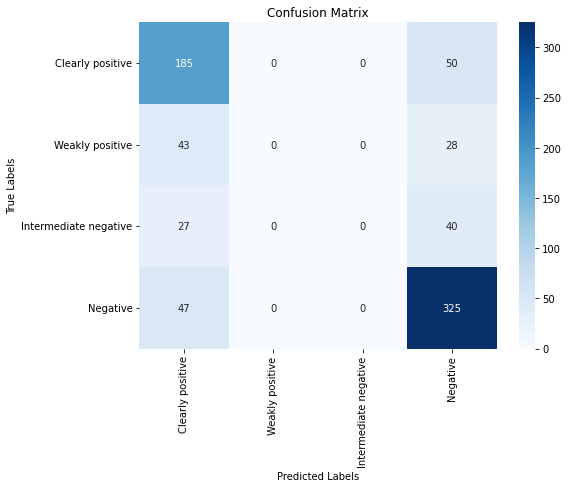

In [9]:
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Example true labels and predictions
y_true = df_filtered["Truth"]
y_pred = df_filtered["Prediction"]

# Define the class names
# Define the class names in the desired order, excluding 'Unknown'
desired_order = ['Clearly positive','Weakly positive','Intermediate negative','Negative']
# Filter out 'Unknown' class from both true and predicted labels
mask = (y_true != 'Unknown') & (y_pred != 'Unknown')
y_true_filtered = y_true[mask]
y_pred_filtered = y_pred[mask]

# Compute the confusion matrix
cm_complete = confusion_matrix(y_true_filtered, y_pred_filtered, labels=desired_order)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_complete , annot=True, fmt='d', cmap='Blues', xticklabels=desired_order, yticklabels=desired_order)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [10]:
# 初始化敏感性和特异性的列表
sensitivities = []
specificities = []
class_weights = []

# 遍历每个类别计算敏感性和特异性
for i in range(len(cm_complete)):
    TP = cm_complete[i, i]
    FN = np.sum(cm_complete[i, :]) - TP
    FP = np.sum(cm_complete[:, i]) - TP
    TN = np.sum(cm_complete) - (TP + FN + FP)
    
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    
    sensitivities.append(sensitivity)
    specificities.append(specificity)
    
    # 权重为该类别的真实样本数
    class_weights.append(TP + FN)

# 计算加权平均敏感性和特异性
weighted_sensitivity = np.average(sensitivities, weights=class_weights)
weighted_specificity = np.average(specificities, weights=class_weights)

print(f"Weighted Sensitivity: {weighted_sensitivity:.4f}")
print(f"Weighted Specificity: {weighted_specificity:.4f}")

Weighted Sensitivity: 0.6846
Weighted Specificity: 0.7697


In [11]:
228/306

0.7450980392156863

In [12]:
from sklearn.metrics import roc_auc_score
import pandas as pd

# Assuming MMSE is a pandas Series and filtered_df is a DataFrame

# Create a dictionary to store the AUC for each class
auc_scores = {}
cate= ["Clearly positive","Weakly positive","Intermediate negative","Negative"]
class_weights = []

# Iterate through each class in filtered_df columns
for i,cls in enumerate(cate):
    # Convert MMSE to binary: 1 if the class matches, 0 otherwise
    binary_true_labels = ( df_filtered["Truth"]== cls).astype(int)
    
    # Get the predicted probabilities for the current class
    pred_probs = df_filtered.iloc[:,i+1]
    
    # Calculate the AUC for the current class
    auc_number = roc_auc_score(binary_true_labels, pred_probs)
    class_weights.append(sum(df_filtered["Truth"] == cls))
    # Store the AUC in the dictionary
    auc_scores[cls] = auc_number

# Convert the dictionary to a DataFrame for easier viewing
auc_df = pd.DataFrame.from_dict(auc_scores, orient='index', columns=['AUC'])
print(auc_df)


                            AUC
Clearly positive       0.876345
Weakly positive        0.627283
Intermediate negative  0.625765
Negative               0.864388


In [13]:
weighted_auc = np.average(auc_df['AUC'], weights=class_weights)

In [14]:
class_weights

[235, 71, 67, 372]

## HABS

In [15]:
import pandas as pd
result_habs=pd.read_csv("D:\\Research\\AD\\ADLLM\\ADNI process 9\\HABS-HD\\HABS-HD-results\\HABS_probability_abeta.csv")

In [16]:
df=result_habs

In [17]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score

# Assuming you have loaded your dataset in df
# df = pd.read_csv('your_dataset.csv')

# Step 1: Rename the columns to remove the "Abeta-" prefix
df.rename(columns={
    'Abeta-Clearly positive': 'Clearly positive',
    'Abeta-Weakly positive': 'Weakly positive',
    'Abeta-Intermediate negative': 'Intermediate negative',
    'Abeta-Negative': 'Negative'
}, inplace=True)

# Step 2: Generate 'Prediction' column based on max probability
df['Prediction'] = df[['Clearly positive', 'Weakly positive', 'Intermediate negative', 'Negative']].idxmax(axis=1)

# Step 3: Filter out rows where 'Truth' is 'Unknown'
df_filtered = df[df['Truth'] != 'Unknown.']
df_filtered

,Index,Clearly positive,Weakly positive,Intermediate negative,Negative,Truth,Prediction
0,0,0.038423,0.029003,0.098117,0.834457,Negative,Negative
1,1,0.019049,0.016040,0.075338,0.889572,Negative,Negative
2,2,0.017363,0.013523,0.064513,0.904601,Negative,Negative
3,3,0.021605,0.016055,0.071954,0.890386,Negative,Negative
4,4,0.017089,0.013102,0.065507,0.904302,Negative,Negative
...,...,...,...,...,...,...,...
731,731,0.060058,0.034220,0.102161,0.803561,Negative,Negative
733,733,0.058537,0.027222,0.067376,0.846864,Negative,Negative
736,736,0.074350,0.034576,0.079145,0.811928,Negative,Negative
738,738,0.113965,0.049787,0.127137,0.709111,Weakly positive,Negative


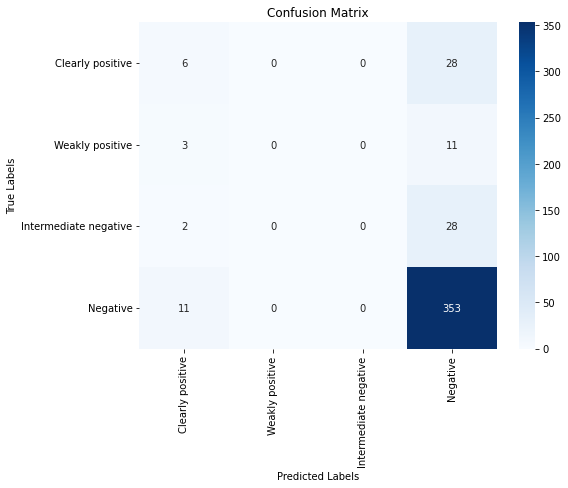

In [18]:
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Example true labels and predictions
y_true = df_filtered["Truth"]
y_pred = df_filtered["Prediction"]

# Define the class names
# Define the class names in the desired order, excluding 'Unknown'
desired_order = ['Clearly positive','Weakly positive','Intermediate negative','Negative']
# Filter out 'Unknown' class from both true and predicted labels
mask = (y_true != 'Unknown') & (y_pred != 'Unknown')
y_true_filtered = y_true[mask]
y_pred_filtered = y_pred[mask]

# Compute the confusion matrix
cm_complete = confusion_matrix(y_true_filtered, y_pred_filtered, labels=desired_order)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_complete , annot=True, fmt='d', cmap='Blues', xticklabels=desired_order, yticklabels=desired_order)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [19]:
# 初始化敏感性和特异性的列表
sensitivities = []
specificities = []
class_weights = []

# 遍历每个类别计算敏感性和特异性
for i in range(len(cm_complete)):
    TP = cm_complete[i, i]
    FN = np.sum(cm_complete[i, :]) - TP
    FP = np.sum(cm_complete[:, i]) - TP
    TN = np.sum(cm_complete) - (TP + FN + FP)
    
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    
    sensitivities.append(sensitivity)
    specificities.append(specificity)
    
    # 权重为该类别的真实样本数
    class_weights.append(TP + FN)

# 计算加权平均敏感性和特异性
weighted_sensitivity = np.average(sensitivities, weights=class_weights)
weighted_specificity = np.average(specificities, weights=class_weights)

print(f"Weighted Sensitivity: {weighted_sensitivity:.4f}")
print(f"Weighted Specificity: {weighted_specificity:.4f}")

Weighted Sensitivity: 0.8122
Weighted Specificity: 0.2896


In [20]:
from sklearn.metrics import roc_auc_score
import pandas as pd

# Assuming MMSE is a pandas Series and filtered_df is a DataFrame

# Create a dictionary to store the AUC for each class
auc_scores = {}
cate= ["Clearly positive","Weakly positive","Intermediate negative","Negative"]
class_weights = []

# Iterate through each class in filtered_df columns
for i,cls in enumerate(cate):
    # Convert MMSE to binary: 1 if the class matches, 0 otherwise
    binary_true_labels = ( df_filtered["Truth"]== cls).astype(int)
    
    # Get the predicted probabilities for the current class
    pred_probs = df_filtered.iloc[:,i+1]
    
    # Calculate the AUC for the current class
    auc_number = roc_auc_score(binary_true_labels, pred_probs)
    class_weights.append(sum(df_filtered["Truth"] == cls))
    # Store the AUC in the dictionary
    auc_scores[cls] = auc_number

# Convert the dictionary to a DataFrame for easier viewing
auc_df = pd.DataFrame.from_dict(auc_scores, orient='index', columns=['AUC'])
print(auc_df)


                            AUC
Clearly positive       0.794983
Weakly positive        0.726802
Intermediate negative  0.699595
Negative               0.778494


In [21]:
weighted_auc = np.average(auc_df['AUC'], weights=class_weights)

In [22]:
weighted_auc 

0.7727699193643225

In [23]:
9/48

0.1875

## POINTER

In [24]:
import pandas as pd
result_pointer=pd.read_csv("D:\\Research\\AD\\ADLLM\\ADNI process 9\\POINTER\\POINTER-results\\POINTER_probability_abeta.csv")

In [25]:
df=result_pointer

In [26]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score

# Assuming you have loaded your dataset in df
# df = pd.read_csv('your_dataset.csv')

# Step 1: Rename the columns to remove the "Abeta-" prefix
df.rename(columns={
    'Abeta-Clearly positive': 'Clearly positive',
    'Abeta-Weakly positive': 'Weakly positive',
    'Abeta-Intermediate negative': 'Intermediate negative',
    'Abeta-Negative': 'Negative'
}, inplace=True)

# Step 2: Generate 'Prediction' column based on max probability
df['Prediction'] = df[['Clearly positive', 'Weakly positive', 'Intermediate negative', 'Negative']].idxmax(axis=1)

# Step 3: Filter out rows where 'Truth' is 'Unknown'
df_filtered = df[df['Truth'] != 'Unknown.']
df_filtered

,Index,Clearly positive,Weakly positive,Intermediate negative,Negative,Truth,Prediction
0,0,0.022716,0.035183,0.141342,0.800759,Negative,Negative
1,1,0.111025,0.075123,0.204206,0.609646,Negative,Negative
2,2,0.048788,0.047287,0.175694,0.728230,Negative,Negative
3,3,0.028237,0.038595,0.120754,0.812413,Negative,Negative
4,4,0.041581,0.047860,0.161907,0.748652,Negative,Negative
...,...,...,...,...,...,...,...
183,183,0.103140,0.068706,0.225278,0.602876,Intermediate negative,Negative
184,184,0.058784,0.054366,0.192746,0.694104,Negative,Negative
185,185,0.070510,0.072748,0.166523,0.690218,Negative,Negative
186,186,0.017852,0.033876,0.114602,0.833671,Negative,Negative


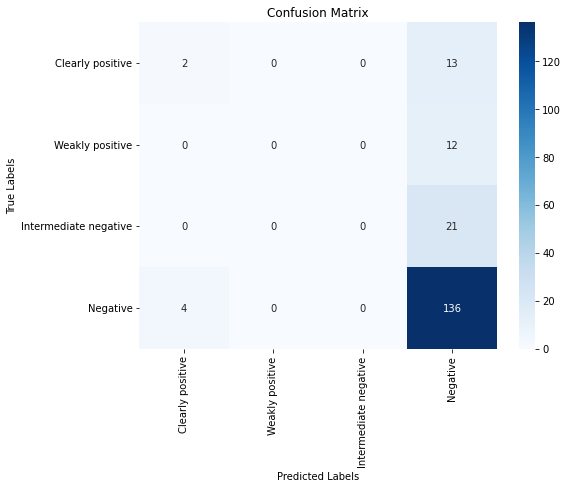

In [27]:
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Example true labels and predictions
y_true = df_filtered["Truth"]
y_pred = df_filtered["Prediction"]

# Define the class names
# Define the class names in the desired order, excluding 'Unknown'
desired_order = ['Clearly positive','Weakly positive','Intermediate negative','Negative']
# Filter out 'Unknown' class from both true and predicted labels
mask = (y_true != 'Unknown') & (y_pred != 'Unknown')
y_true_filtered = y_true[mask]
y_pred_filtered = y_pred[mask]

# Compute the confusion matrix
cm_complete = confusion_matrix(y_true_filtered, y_pred_filtered, labels=desired_order)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_complete , annot=True, fmt='d', cmap='Blues', xticklabels=desired_order, yticklabels=desired_order)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [28]:
2/27

0.07407407407407407

In [29]:
# 初始化敏感性和特异性的列表
sensitivities = []
specificities = []
class_weights = []

# 遍历每个类别计算敏感性和特异性
for i in range(len(cm_complete)):
    TP = cm_complete[i, i]
    FN = np.sum(cm_complete[i, :]) - TP
    FP = np.sum(cm_complete[:, i]) - TP
    TN = np.sum(cm_complete) - (TP + FN + FP)
    
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    
    sensitivities.append(sensitivity)
    specificities.append(specificity)
    
    # 权重为该类别的真实样本数
    class_weights.append(TP + FN)

# 计算加权平均敏感性和特异性
weighted_sensitivity = np.average(sensitivities, weights=class_weights)
weighted_specificity = np.average(specificities, weights=class_weights)

print(f"Weighted Sensitivity: {weighted_sensitivity:.4f}")
print(f"Weighted Specificity: {weighted_specificity:.4f}")

Weighted Sensitivity: 0.7340
Weighted Specificity: 0.2845


In [30]:
from sklearn.metrics import roc_auc_score
import pandas as pd

# Assuming MMSE is a pandas Series and filtered_df is a DataFrame

# Create a dictionary to store the AUC for each class
auc_scores = {}
cate= ["Clearly positive","Weakly positive","Intermediate negative","Negative"]
class_weights = []

# Iterate through each class in filtered_df columns
for i,cls in enumerate(cate):
    # Convert MMSE to binary: 1 if the class matches, 0 otherwise
    binary_true_labels = ( df_filtered["Truth"]== cls).astype(int)
    
    # Get the predicted probabilities for the current class
    pred_probs = df_filtered.iloc[:,i+1]
    
    # Calculate the AUC for the current class
    auc_number = roc_auc_score(binary_true_labels, pred_probs)
    class_weights.append(sum(df_filtered["Truth"] == cls))
    # Store the AUC in the dictionary
    auc_scores[cls] = auc_number

# Convert the dictionary to a DataFrame for easier viewing
auc_df = pd.DataFrame.from_dict(auc_scores, orient='index', columns=['AUC'])
print(auc_df)


                            AUC
Clearly positive       0.683622
Weakly positive        0.708807
Intermediate negative  0.649273
Negative               0.710863


In [31]:
weighted_auc = np.average(auc_df['AUC'], weights=class_weights)

In [32]:
weighted_auc

0.701678622077409

## A4

In [33]:
import pandas as pd
result_a4=pd.read_csv("D:\\Research\\AD\\ADLLM\\ADNI process 9\\A4\\A4-results\\A4_probability_abeta.csv")

In [34]:
df=result_a4

In [35]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score

# Assuming you have loaded your dataset in df
# df = pd.read_csv('your_dataset.csv')

# Step 1: Rename the columns to remove the "Abeta-" prefix
df.rename(columns={
    'Abeta-Clearly positive': 'Clearly positive',
    'Abeta-Weakly positive': 'Weakly positive',
    'Abeta-Intermediate negative': 'Intermediate negative',
    'Abeta-Negative': 'Negative'
}, inplace=True)

# Step 2: Generate 'Prediction' column based on max probability
df['Prediction'] = df[['Clearly positive', 'Weakly positive', 'Intermediate negative', 'Negative']].idxmax(axis=1)

# Step 3: Filter out rows where 'Truth' is 'Unknown'
df_filtered = df[df['Truth'] != 'Unknown.']
df_filtered

,Index,Clearly positive,Weakly positive,Intermediate negative,Negative,Truth,Prediction
0,0,0.053494,0.043661,0.140939,0.761907,Negative,Negative
1,1,0.052433,0.037180,0.127760,0.782627,Weakly positive,Negative
2,2,0.178795,0.089904,0.205792,0.525509,Clearly positive,Negative
3,3,0.213081,0.086092,0.213081,0.487746,Clearly positive,Negative
4,4,0.072631,0.034849,0.135692,0.756829,Negative,Negative
...,...,...,...,...,...,...,...
435,435,0.051732,0.035004,0.116581,0.796683,Intermediate negative,Negative
436,436,0.160329,0.078138,0.219144,0.542388,Clearly positive,Negative
437,437,0.054313,0.035619,0.124323,0.785745,Intermediate negative,Negative
438,438,0.059286,0.038278,0.133603,0.768833,Intermediate negative,Negative


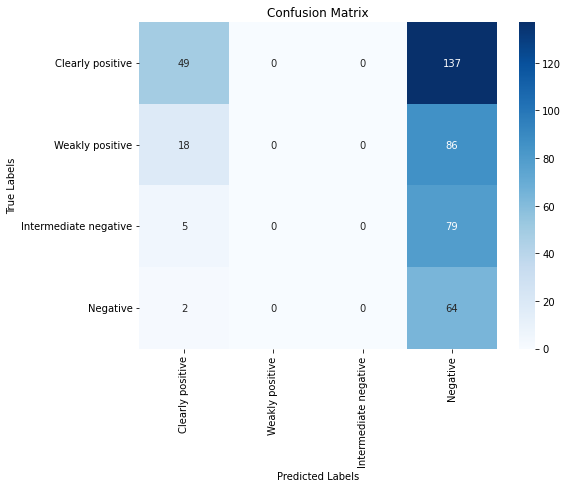

In [36]:
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Example true labels and predictions
y_true = df_filtered["Truth"]
y_pred = df_filtered["Prediction"]

# Define the class names
# Define the class names in the desired order, excluding 'Unknown'
desired_order = ['Clearly positive','Weakly positive','Intermediate negative','Negative']
# Filter out 'Unknown' class from both true and predicted labels
mask = (y_true != 'Unknown') & (y_pred != 'Unknown')
y_true_filtered = y_true[mask]
y_pred_filtered = y_pred[mask]

# Compute the confusion matrix
cm_complete = confusion_matrix(y_true_filtered, y_pred_filtered, labels=desired_order)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_complete , annot=True, fmt='d', cmap='Blues', xticklabels=desired_order, yticklabels=desired_order)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [37]:
67/(137+86+67)

0.23103448275862068

In [38]:
137+86+67

290

In [39]:
# 初始化敏感性和特异性的列表
sensitivities = []
specificities = []
class_weights = []

# 遍历每个类别计算敏感性和特异性
for i in range(len(cm_complete)):
    TP = cm_complete[i, i]
    FN = np.sum(cm_complete[i, :]) - TP
    FP = np.sum(cm_complete[:, i]) - TP
    TN = np.sum(cm_complete) - (TP + FN + FP)
    
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    
    sensitivities.append(sensitivity)
    specificities.append(specificity)
    
    # 权重为该类别的真实样本数
    class_weights.append(TP + FN)

# 计算加权平均敏感性和特异性
weighted_sensitivity = np.average(sensitivities, weights=class_weights)
weighted_specificity = np.average(specificities, weights=class_weights)

print(f"Weighted Sensitivity: {weighted_sensitivity:.4f}")
print(f"Weighted Specificity: {weighted_specificity:.4f}")

Weighted Sensitivity: 0.2568
Weighted Specificity: 0.8373


In [40]:
from sklearn.metrics import roc_auc_score
import pandas as pd

# Assuming MMSE is a pandas Series and filtered_df is a DataFrame

# Create a dictionary to store the AUC for each class
auc_scores = {}
cate= ["Clearly positive","Weakly positive","Intermediate negative","Negative"]
class_weights = []

# Iterate through each class in filtered_df columns
for i,cls in enumerate(cate):
    # Convert MMSE to binary: 1 if the class matches, 0 otherwise
    binary_true_labels = ( df_filtered["Truth"]== cls).astype(int)
    
    # Get the predicted probabilities for the current class
    pred_probs = df_filtered.iloc[:,i+1]
    
    # Calculate the AUC for the current class
    auc_number = roc_auc_score(binary_true_labels, pred_probs)
    class_weights.append(sum(df_filtered["Truth"] == cls))
    # Store the AUC in the dictionary
    auc_scores[cls] = auc_number

# Convert the dictionary to a DataFrame for easier viewing
auc_df = pd.DataFrame.from_dict(auc_scores, orient='index', columns=['AUC'])
print(auc_df)


                            AUC
Clearly positive       0.721658
Weakly positive        0.489097
Intermediate negative  0.406066
Negative               0.746597


In [41]:
weighted_auc = np.average(auc_df['AUC'], weights=class_weights)

In [42]:
weighted_auc

0.6101803852649563

## Abeta binary-A4

In [68]:
result_a4=result_a4[result_a4["Truth"]!="Unknown."]

In [69]:
df=result_a4
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score

# Assuming you have loaded your dataset in df
# df = pd.read_csv('your_dataset.csv')

# Step 1: Rename the columns to remove the "Abeta-" prefix
df.rename(columns={
    'Abeta-Clearly positive': 'Clearly positive',
    'Abeta-Weakly positive': 'Weakly positive',
    'Abeta-Intermediate negative': 'Intermediate negative',
    'Abeta-Negative': 'Negative'
}, inplace=True)

# Step 2: Generate 'Prediction' column based on max probability
df['Prediction'] = df[['Clearly positive', 'Weakly positive', 'Intermediate negative', 'Negative']].idxmax(axis=1)

# Step 3: Filter out rows where 'Truth' is 'Unknown'
df_filtered = df[df['Truth'] != 'Unknown.']
df_filtered

,Index,Clearly positive,Weakly positive,Intermediate negative,Negative,Truth,Prediction
0,0,0.053494,0.043661,0.140939,0.761907,Negative,Negative
1,1,0.052433,0.037180,0.127760,0.782627,Weakly positive,Negative
2,2,0.178795,0.089904,0.205792,0.525509,Clearly positive,Negative
3,3,0.213081,0.086092,0.213081,0.487746,Clearly positive,Negative
4,4,0.072631,0.034849,0.135692,0.756829,Negative,Negative
...,...,...,...,...,...,...,...
435,435,0.051732,0.035004,0.116581,0.796683,Intermediate negative,Negative
436,436,0.160329,0.078138,0.219144,0.542388,Clearly positive,Negative
437,437,0.054313,0.035619,0.124323,0.785745,Intermediate negative,Negative
438,438,0.059286,0.038278,0.133603,0.768833,Intermediate negative,Negative


In [78]:
df=df_filtered

df['Binary Truth'] = df['Truth'].apply(lambda x: 1 if x=='Intermediate negative' or x=='Clearly positive' or x=="Weakly positive" else 0)

In [79]:
df['Binary Truth'].value_counts()

Binary Truth
1    374
0     66
Name: count, dtype: int64

In [80]:
df=df_filtered

df=df_filtered

df['Binary Truth'] = df['Truth'].apply(lambda x: 1 if x=='Intermediate negative' or x=='Clearly positive' or x=="Weakly positive" else 0)
# Redefining binary outcomes based on the sum of the probabilities for clearly positive and weakly positive
df['Positive Probability'] = df['Clearly positive'] + df['Weakly positive']+df['Intermediate negative'] 
df['Negative Probability'] = df['Negative']

# Recalculating binary truth and binary prediction based on higher probability
df['Binary Prediction'] = df.apply(lambda x: 1 if x['Positive Probability'] > x['Negative Probability'] else 0, axis=1)

# Recalculate accuracy, specificity, and AUC
accuracy = accuracy_score(df['Binary Truth'], df['Binary Prediction'])
tn, fp, fn, tp = confusion_matrix(df['Binary Truth'], df['Binary Prediction']).ravel()
specificity = tn / (tn + fp)
auc = roc_auc_score(df['Binary Truth'], df['Positive Probability'])




In [81]:
print(accuracy)

0.5136363636363637


In [82]:
print(specificity)

0.9090909090909091


In [83]:
print(auc)

0.7465969859017988


## Abeta-binary-Pointer

In [84]:
df=result_pointer
df.rename(columns={
    'Abeta-Clearly positive': 'Clearly positive',
    'Abeta-Weakly positive': 'Weakly positive',
    'Abeta-Intermediate negative': 'Intermediate negative',
    'Abeta-Negative': 'Negative'
}, inplace=True)

# Step 2: Generate 'Prediction' column based on max probability
df['Prediction'] = df[['Clearly positive', 'Weakly positive', 'Intermediate negative', 'Negative']].idxmax(axis=1)

# Step 3: Filter out rows where 'Truth' is 'Unknown'
df_filtered = df[df['Truth'] != 'Unknown.']
df=df_filtered
df['Binary Truth'] = df['Truth'].apply(lambda x: 1 if x=='Intermediate negative' or x=='Clearly positive' or x=="Weakly positive" else 0)
# Redefining binary outcomes based on the sum of the probabilities for clearly positive and weakly positive
df['Positive Probability'] = df['Clearly positive'] + df['Weakly positive']+df['Intermediate negative']
df['Negative Probability'] = df['Negative']

# Recalculating binary truth and binary prediction based on higher probability
df['Binary Prediction'] = df.apply(lambda x: 1 if x['Positive Probability'] > x['Negative Probability'] else 0, axis=1)

# Recalculate accuracy, specificity, and AUC
accuracy = accuracy_score(df['Binary Truth'], df['Binary Prediction'])
tn, fp, fn, tp = confusion_matrix(df['Binary Truth'], df['Binary Prediction']).ravel()
specificity = tn / (tn + fp)
auc = roc_auc_score(df['Binary Truth'], df['Positive Probability'])




In [85]:
print(accuracy)

0.7446808510638298


In [86]:
print(specificity)

0.9142857142857143


In [87]:
print(auc)

0.7108630952380952


## Abeta-binary-habs-hd

In [88]:
df=result_habs
df.rename(columns={
    'Abeta-Clearly positive': 'Clearly positive',
    'Abeta-Weakly positive': 'Weakly positive',
    'Abeta-Intermediate negative': 'Intermediate negative',
    'Abeta-Negative': 'Negative'
}, inplace=True)

# Step 2: Generate 'Prediction' column based on max probability
df['Prediction'] = df[['Clearly positive', 'Weakly positive', 'Intermediate negative', 'Negative']].idxmax(axis=1)

# Step 3: Filter out rows where 'Truth' is 'Unknown'
df_filtered = df[df['Truth'] != 'Unknown.']
df=df_filtered
df['Binary Truth'] = df['Truth'].apply(lambda x: 1 if x=='Intermediate negative' or x=='Clearly positive' or x=="Weakly positive" else 0)
# Redefining binary outcomes based on the sum of the probabilities for clearly positive and weakly positive
df['Positive Probability'] = df['Clearly positive'] + df['Weakly positive']+df['Intermediate negative'] 
df['Negative Probability'] = df['Negative']

# Recalculating binary truth and binary prediction based on higher probability
df['Binary Prediction'] = df.apply(lambda x: 1 if x['Positive Probability'] > x['Negative Probability'] else 0, axis=1)

# Recalculate accuracy, specificity, and AUC
accuracy = accuracy_score(df['Binary Truth'], df['Binary Prediction'])
tn, fp, fn, tp = confusion_matrix(df['Binary Truth'], df['Binary Prediction']).ravel()
specificity = tn / (tn + fp)
auc = roc_auc_score(df['Binary Truth'], df['Positive Probability'])




C:\Users\25110\AppData\Local\Temp/ipykernel_1480/4210919866.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Binary Truth'] = df['Truth'].apply(lambda x: 1 if x=='Intermediate negative' or x=='Clearly positive' or x=="Weakly positive" else 0)
C:\Users\25110\AppData\Local\Temp/ipykernel_1480/4210919866.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Positive Probability'] = df['Clearly positive'] + df['Weakly positive']+df['Intermediate negative']
C:\Users\25110\AppData\Local\Temp/ipykernel_

In [89]:
print(accuracy)

0.8054298642533937


In [90]:
print(specificity)

0.8956043956043956


In [91]:
print(auc)

0.7784939419554804


## Abeta-binary-ADNI

In [57]:
result_adni

,Index,Clearly positive,Weakly positive,Intermediate negative,Negative,Truth,Prediction
0,0,0.000000,0.000000,0.000000,0.000000,Unknown.,Clearly positive
1,1,0.000000,0.000000,0.000000,0.000000,Unknown.,Clearly positive
2,2,0.000000,0.000000,0.000000,0.000000,Unknown.,Clearly positive
3,3,0.000000,0.000000,0.000000,0.000000,Unknown.,Clearly positive
4,4,0.000000,0.000000,0.000000,0.000000,Unknown.,Clearly positive
...,...,...,...,...,...,...,...
2459,2459,0.017942,0.014417,0.061653,0.905988,Negative,Negative
2460,2460,0.229924,0.094360,0.165608,0.510108,Negative,Negative
2461,2461,0.394677,0.102958,0.159464,0.342901,Clearly positive,Clearly positive
2462,2462,0.000000,0.000000,0.000000,0.000000,Unknown.,Clearly positive


In [92]:
df=result_adni
df.rename(columns={
    'Abeta-Clearly positive': 'Clearly positive',
    'Abeta-Weakly positive': 'Weakly positive',
    'Abeta-Intermediate negative': 'Intermediate negative',
    'Abeta-Negative': 'Negative'
}, inplace=True)

# Step 2: Generate 'Prediction' column based on max probability
df['Prediction'] = df[['Clearly positive', 'Weakly positive', 'Intermediate negative', 'Negative']].idxmax(axis=1)

# Step 3: Filter out rows where 'Truth' is 'Unknown'
df_filtered = df[df['Truth'] != 'Unknown.']
df=df_filtered
df['Binary Truth'] = df['Truth'].apply(lambda x: 1 if x=='Intermediate negative' or x=='Clearly positive' or x=="Weakly positive" else 0)
# Redefining binary outcomes based on the sum of the probabilities for clearly positive and weakly positive
df['Positive Probability'] = df['Clearly positive'] + df['Weakly positive']+df['Intermediate negative']
df['Negative Probability'] =  df['Negative']

# Recalculating binary truth and binary prediction based on higher probability
df['Binary Prediction'] = df.apply(lambda x: 1 if x['Positive Probability'] > x['Negative Probability'] else 0, axis=1)

# Recalculate accuracy, specificity, and AUC
accuracy = accuracy_score(df['Binary Truth'], df['Binary Prediction'])
tn, fp, fn, tp = confusion_matrix(df['Binary Truth'], df['Binary Prediction']).ravel()
specificity = tn / (tn + fp)
auc = roc_auc_score(df['Binary Truth'], df['Positive Probability'])




C:\Users\25110\AppData\Local\Temp/ipykernel_1480/3913961115.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Binary Truth'] = df['Truth'].apply(lambda x: 1 if x=='Intermediate negative' or x=='Clearly positive' or x=="Weakly positive" else 0)
C:\Users\25110\AppData\Local\Temp/ipykernel_1480/3913961115.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Positive Probability'] = df['Clearly positive'] + df['Weakly positive']+df['Intermediate negative']
C:\Users\25110\AppData\Local\Temp/ipykernel_

In [93]:
print(accuracy)

0.8


In [94]:
print(specificity)

0.8198924731182796


In [95]:
print(auc)

0.8643878462913316


In [96]:
df=pd.read_csv("D:\\Research\\AD\\ADLLM\\ADNI process 9\\ADNI\\GB\\adni_testing_result.csv")
df['Binary Truth'] = df['Truth'].apply(lambda x: 1 if x=='Intermediate negative' or x=='Clearly positive' or x=="Weakly positive" else 0)
# Redefining binary outcomes based on the sum of the probabilities for clearly positive and weakly positive
df['Positive Probability'] = df['Clearly positive'] + df['Weakly positive']+df['Intermediate Negative'] 
df['Negative Probability'] =  df['Negative']


# Recalculating binary truth and binary prediction based on higher probability
df['Binary Prediction'] = df.apply(lambda x: 1 if x['Positive Probability'] > x['Negative Probability'] else 0, axis=1)

# Recalculate accuracy, specificity, and AUC
accuracy = accuracy_score(df['Binary Truth'], df['Binary Prediction'])
tn, fp, fn, tp = confusion_matrix(df['Binary Truth'], df['Binary Prediction']).ravel()
specificity = tn / (tn + fp)
auc = roc_auc_score(df['Binary Truth'], df['Positive Probability'])
print(accuracy)
print(specificity)
print(auc)



0.7723035952063915
0.8153034300791556
0.8703932249553155


In [97]:
df=pd.read_csv("D:\\Research\\AD\\ADLLM\\ADNI process 9\\HABS-HD\\GB\\habs_testing_result.csv")
df['Binary Truth'] = df['Truth'].apply(lambda x: 1 if x=='Intermediate negative' or x=='Clearly positive' or x=="Weakly positive" else 0)
# Redefining binary outcomes based on the sum of the probabilities for clearly positive and weakly positive
df['Positive Probability'] = df['Clearly positive'] + df['Weakly positive']+df['Intermediate Negative']
df['Negative Probability'] =  df['Negative']


# Recalculating binary truth and binary prediction based on higher probability
df['Binary Prediction'] = df.apply(lambda x: 1 if x['Positive Probability'] > x['Negative Probability'] else 0, axis=1)

# Recalculate accuracy, specificity, and AUC
accuracy = accuracy_score(df['Binary Truth'], df['Binary Prediction'])
tn, fp, fn, tp = confusion_matrix(df['Binary Truth'], df['Binary Prediction']).ravel()
specificity = tn / (tn + fp)
auc = roc_auc_score(df['Binary Truth'], df['Positive Probability'])
print(accuracy)
print(specificity)
print(auc)



0.8393665158371041
1.0
0.7518590998043053


In [98]:
df=pd.read_csv("D:\\Research\\AD\\ADLLM\\ADNI process 9\\POINTER\\GB\\pointer_testing_result.csv")
df['Binary Truth'] = df['Truth'].apply(lambda x: 1 if x=='Intermediate negative' or x=='Clearly positive' or x=="Weakly positive" else 0)
# Redefining binary outcomes based on the sum of the probabilities for clearly positive and weakly positive
df['Positive Probability'] = df['Clearly positive'] + df['Weakly positive']+df['Intermediate Negative'] 
df['Negative Probability'] =  df['Negative']


# Recalculating binary truth and binary prediction based on higher probability
df['Binary Prediction'] = df.apply(lambda x: 1 if x['Positive Probability'] > x['Negative Probability'] else 0, axis=1)

# Recalculate accuracy, specificity, and AUC
accuracy = accuracy_score(df['Binary Truth'], df['Binary Prediction'])
tn, fp, fn, tp = confusion_matrix(df['Binary Truth'], df['Binary Prediction']).ravel()
specificity = tn / (tn + fp)
auc = roc_auc_score(df['Binary Truth'], df['Positive Probability'])
print(accuracy)
print(specificity)
print(auc)



0.7446808510638298
0.9929078014184397
0.6720989889844575


In [99]:
df=pd.read_csv("D:\\Research\\AD\\ADLLM\\ADNI process 9\\A4\\GB\\A4_testing_result_abeta.csv")
df['Binary Truth'] = df['Truth'].apply(lambda x: 1 if x=='Intermediate negative' or x=='Clearly positive' or x=="Weakly positive" else 0)
# Redefining binary outcomes based on the sum of the probabilities for clearly positive and weakly positive
df['Positive Probability'] = df['Clearly positive'] + df['Weakly positive']+df['Intermediate Negative']
df['Negative Probability'] =   df['Negative']


# Recalculating binary truth and binary prediction based on higher probability
df['Binary Prediction'] = df.apply(lambda x: 1 if x['Positive Probability'] > x['Negative Probability'] else 0, axis=1)

# Recalculate accuracy, specificity, and AUC
accuracy = accuracy_score(df['Binary Truth'], df['Binary Prediction'])
tn, fp, fn, tp = confusion_matrix(df['Binary Truth'], df['Binary Prediction']).ravel()
specificity = tn / (tn + fp)
auc = roc_auc_score(df['Binary Truth'], df['Positive Probability'])
print(accuracy)
print(specificity)
print(auc)



0.5954545454545455
0.7424242424242424
0.731729055258467


## Meta tau ADNI

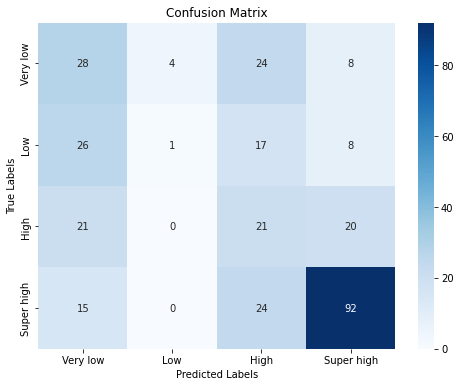

In [118]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
result_adni=pd.read_csv("D:\\Research\\AD\\ADLLM\\ADNI process 9\\ADNI\\ADNI-results\\ADNI_probability_meta_tau.csv")


# Assuming you have loaded your dataset in df
# df = pd.read_csv('your_dataset.csv')
df=result_adni
# Step 1: Rename the columns to remove the "Abeta-" prefixAbeta-Slow	Abeta-Moderate	Abeta-Fast	Abeta-Not decreasing

df.rename(columns={
    'Meta Tau-Low': 'Low',
    'Meta Tau-Very low': 'Very low',
    'Meta Tau-Super high': 'Super high',
    'Meta Tau-High':'High'
}, inplace=True)

# # Step 2: Generate 'Prediction' column based on max probability
df['Prediction'] = df[['Very low', 'Low',  'High','Super high']].idxmax(axis=1)

# # Step 3: Filter out rows where 'Truth' is 'Unknown'
df_filtered = df[df['Truth'] != 'Unknown.']
df_filtered
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Example true labels and predictions
y_true = df_filtered["Truth"]
y_pred = df_filtered["Prediction"]

# Define the class names
# Define the class names in the desired order, excluding 'Unknown'
desired_order = ['Very low', 'Low',  'High','Super high']
# Filter out 'Unknown' class from both true and predicted labels
mask = (y_true != 'Unknown.') & (y_pred != 'Unknown.')
y_true_filtered = y_true[mask]
y_pred_filtered = y_pred[mask]

# Compute the confusion matrix
cm= confusion_matrix(y_true_filtered, y_pred_filtered, labels=desired_order)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=desired_order, yticklabels=desired_order)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [119]:
# 初始化敏感性和特异性的列表
sensitivities = []
specificities = []
class_weights = []

# 遍历每个类别计算敏感性和特异性
for i in range(len(cm)):
    TP = cm[i, i]
    FN = np.sum(cm[i, :]) - TP
    FP = np.sum(cm[:, i]) - TP
    TN = np.sum(cm) - (TP + FN + FP)
    
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    
    sensitivities.append(sensitivity)
    specificities.append(specificity)
    
    # 权重为该类别的真实样本数
    class_weights.append(TP + FN)

# 计算加权平均敏感性和特异性
weighted_sensitivity = np.average(sensitivities, weights=class_weights)
weighted_specificity = np.average(specificities, weights=class_weights)

print(f"Weighted Sensitivity: {weighted_sensitivity:.4f}")
print(f"Weighted Specificity: {weighted_specificity:.4f}")

Weighted Sensitivity: 0.4595
Weighted Specificity: 0.8064


In [120]:
df_filtered

,Index,Low,Very low,Super high,High,Truth,Prediction
98,98,0.126583,0.152688,0.524673,0.196056,Super high,Super high
206,206,0.232822,0.251741,0.255705,0.259732,Super high,High
280,280,0.184146,0.141189,0.414978,0.259687,Super high,Super high
281,281,0.152502,0.152502,0.462457,0.232538,Super high,Super high
283,283,0.158377,0.168591,0.472825,0.200207,Super high,Super high
...,...,...,...,...,...,...,...
2457,2457,0.075705,0.097208,0.664294,0.162792,Super high,Super high
2458,2458,0.254602,0.326915,0.096636,0.321847,High,Very low
2459,2459,0.244398,0.361196,0.080594,0.313813,Very low,Very low
2460,2460,0.232013,0.262905,0.177891,0.327191,Super high,High


In [121]:
from sklearn.metrics import roc_auc_score
import pandas as pd

# Assuming MMSE is a pandas Series and filtered_df is a DataFrame

# Create a dictionary to store the AUC for each class
auc_scores = {}
cate=["Low","Very low","Super high","High"]
class_weights = []

# Iterate through each class in filtered_df columns
for i,cls in enumerate(cate):
    # Convert MMSE to binary: 1 if the class matches, 0 otherwise
    binary_true_labels = ( df_filtered["Truth"]== cls).astype(int)
#     if i==0 or i==2 or i==3:
#         continue
    # Get the predicted probabilities for the current class
    pred_probs = df_filtered.iloc[:,i+1]
    
    # Calculate the AUC for the current class
    auc_number = roc_auc_score(binary_true_labels, pred_probs)
    class_weights.append(sum(df_filtered["Truth"] == cls))
    # Store the AUC in the dictionary
    auc_scores[cls] = auc_number

# Convert the dictionary to a DataFrame for easier viewing
auc_df = pd.DataFrame.from_dict(auc_scores, orient='index', columns=['AUC'])
print(auc_df)


                 AUC
Low         0.680186
Very low    0.701594
Super high  0.814693
High        0.623547


In [122]:
class_weights

[52, 64, 131, 62]

In [123]:
weighted_auc = np.average(auc_df['AUC'], weights=class_weights)

In [124]:
weighted_auc

0.7302793810719665

## Meta tau HABS-HD

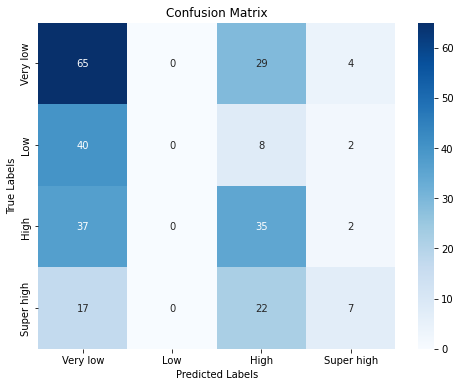

In [125]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
result_habs=pd.read_csv("D:\\Research\\AD\\ADLLM\\ADNI process 9\\HABS-HD\\HABS-HD-results\\HABS_probability_meta_tau.csv")


# Assuming you have loaded your dataset in df
# df = pd.read_csv('your_dataset.csv')
df=result_habs
# Step 1: Rename the columns to remove the "Abeta-" prefixAbeta-Slow	Abeta-Moderate	Abeta-Fast	Abeta-Not decreasing

df.rename(columns={
    'Meta Tau-Low': 'Low',
    'Meta Tau-Very low': 'Very low',
    'Meta Tau-Super high': 'Super high',
    'Meta Tau-High':'High'
}, inplace=True)

# # Step 2: Generate 'Prediction' column based on max probability
df['Prediction'] = df[['Very low', 'Low',  'High','Super high']].idxmax(axis=1)

# # Step 3: Filter out rows where 'Truth' is 'Unknown'
df_filtered = df[df['Truth'] != 'Unknown.']
df_filtered
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Example true labels and predictions
y_true = df_filtered["Truth"]
y_pred = df_filtered["Prediction"]

# Define the class names
# Define the class names in the desired order, excluding 'Unknown'
desired_order = ['Very low', 'Low',  'High','Super high']
# Filter out 'Unknown' class from both true and predicted labels
mask = (y_true != 'Unknown.') & (y_pred != 'Unknown.')
y_true_filtered = y_true[mask]
y_pred_filtered = y_pred[mask]

# Compute the confusion matrix
cm= confusion_matrix(y_true_filtered, y_pred_filtered, labels=desired_order)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=desired_order, yticklabels=desired_order)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [126]:
# 初始化敏感性和特异性的列表
sensitivities = []
specificities = []
class_weights = []

# 遍历每个类别计算敏感性和特异性
for i in range(len(cm)):
    TP = cm[i, i]
    FN = np.sum(cm[i, :]) - TP
    FP = np.sum(cm[:, i]) - TP
    TN = np.sum(cm) - (TP + FN + FP)
    
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    
    sensitivities.append(sensitivity)
    specificities.append(specificity)
    
    # 权重为该类别的真实样本数
    class_weights.append(TP + FN)

# 计算加权平均敏感性和特异性
weighted_sensitivity = np.average(sensitivities, weights=class_weights)
weighted_specificity = np.average(specificities, weights=class_weights)

print(f"Weighted Sensitivity: {weighted_sensitivity:.4f}")
print(f"Weighted Specificity: {weighted_specificity:.4f}")

Weighted Sensitivity: 0.3993
Weighted Specificity: 0.7076


In [127]:
from sklearn.metrics import roc_auc_score
import pandas as pd

# Assuming MMSE is a pandas Series and filtered_df is a DataFrame

# Create a dictionary to store the AUC for each class
auc_scores = {}
cate=["Low","Very low","Super high","High"]
class_weights = []

# Iterate through each class in filtered_df columns
for i,cls in enumerate(cate):
    # Convert MMSE to binary: 1 if the class matches, 0 otherwise
    binary_true_labels = ( df_filtered["Truth"]== cls).astype(int)
#     if i==0 or i==2 or i==3:
#         continue
    # Get the predicted probabilities for the current class
    pred_probs = df_filtered.iloc[:,i+1]
    
    # Calculate the AUC for the current class
    auc_number = roc_auc_score(binary_true_labels, pred_probs)
    class_weights.append(sum(df_filtered["Truth"] == cls))
    # Store the AUC in the dictionary
    auc_scores[cls] = auc_number

# Convert the dictionary to a DataFrame for easier viewing
auc_df = pd.DataFrame.from_dict(auc_scores, orient='index', columns=['AUC'])
print(auc_df)


                 AUC
Low         0.576055
Very low    0.593457
Super high  0.646298
High        0.585678


In [128]:
weighted_auc = np.average(auc_df['AUC'], weights=class_weights)

In [129]:
weighted_auc

0.5971325064861436

## Meta tau Pointer

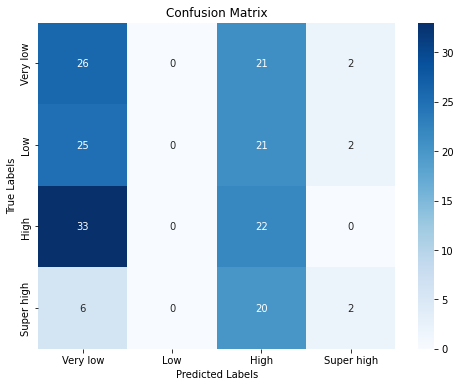

In [130]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
result_pointer=pd.read_csv("D:\\Research\\AD\\ADLLM\\ADNI process 9\\POINTER\\POINTER-results\\POINTER_probability_meta_tau.csv")


# Assuming you have loaded your dataset in df
# df = pd.read_csv('your_dataset.csv')
df=result_pointer
# Step 1: Rename the columns to remove the "Abeta-" prefixAbeta-Slow	Abeta-Moderate	Abeta-Fast	Abeta-Not decreasing

df.rename(columns={
    'Meta Tau-Low': 'Low',
    'Meta Tau-Very low': 'Very low',
    'Meta Tau-Super high': 'Super high',
    'Meta Tau-High':'High'
}, inplace=True)

# # Step 2: Generate 'Prediction' column based on max probability
df['Prediction'] = df[['Very low', 'Low',  'High','Super high']].idxmax(axis=1)

# # Step 3: Filter out rows where 'Truth' is 'Unknown'
df_filtered = df[df['Truth'] != 'Unknown.']
df_filtered
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Example true labels and predictions
y_true = df_filtered["Truth"]
y_pred = df_filtered["Prediction"]

# Define the class names
# Define the class names in the desired order, excluding 'Unknown'
desired_order = ['Very low', 'Low',  'High','Super high']
# Filter out 'Unknown' class from both true and predicted labels
mask = (y_true != 'Unknown.') & (y_pred != 'Unknown.')
y_true_filtered = y_true[mask]
y_pred_filtered = y_pred[mask]

# Compute the confusion matrix
cm= confusion_matrix(y_true_filtered, y_pred_filtered, labels=desired_order)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=desired_order, yticklabels=desired_order)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [131]:
# 初始化敏感性和特异性的列表
sensitivities = []
specificities = []
class_weights = []

# 遍历每个类别计算敏感性和特异性
for i in range(len(cm)):
    TP = cm[i, i]
    FN = np.sum(cm[i, :]) - TP
    FP = np.sum(cm[:, i]) - TP
    TN = np.sum(cm) - (TP + FN + FP)
    
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    
    sensitivities.append(sensitivity)
    specificities.append(specificity)
    
    # 权重为该类别的真实样本数
    class_weights.append(TP + FN)

# 计算加权平均敏感性和特异性
weighted_sensitivity = np.average(sensitivities, weights=class_weights)
weighted_specificity = np.average(specificities, weights=class_weights)

print(f"Weighted Sensitivity: {weighted_sensitivity:.4f}")
print(f"Weighted Specificity: {weighted_specificity:.4f}")

Weighted Sensitivity: 0.2778
Weighted Specificity: 0.7114


In [132]:
from sklearn.metrics import roc_auc_score
import pandas as pd

# Assuming MMSE is a pandas Series and filtered_df is a DataFrame

# Create a dictionary to store the AUC for each class
auc_scores = {}
cate=["Low","Very low","Super high","High"]
class_weights = []

# Iterate through each class in filtered_df columns
for i,cls in enumerate(cate):
    # Convert MMSE to binary: 1 if the class matches, 0 otherwise
    binary_true_labels = ( df_filtered["Truth"]== cls).astype(int)
#     if i==0 or i==2 or i==3:
#         continue
    # Get the predicted probabilities for the current class
    pred_probs = df_filtered.iloc[:,i+1]
    
    # Calculate the AUC for the current class
    auc_number = roc_auc_score(binary_true_labels, pred_probs)
    class_weights.append(sum(df_filtered["Truth"] == cls))
    # Store the AUC in the dictionary
    auc_scores[cls] = auc_number

# Convert the dictionary to a DataFrame for easier viewing
auc_df = pd.DataFrame.from_dict(auc_scores, orient='index', columns=['AUC'])
print(auc_df)


                 AUC
Low         0.488794
Very low    0.531859
Super high  0.554276
High        0.506618


In [133]:
weighted_auc = np.average(auc_df['AUC'], weights=class_weights)

In [134]:
weighted_auc

0.5161495930917587

## Meta tau A4

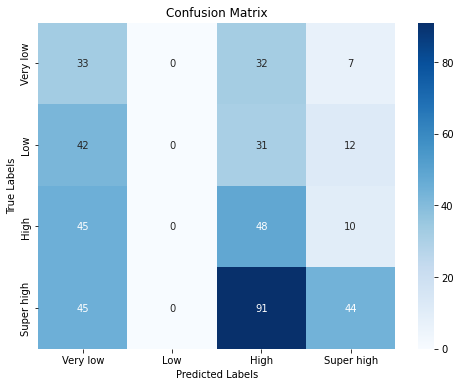

In [136]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
result_a4=pd.read_csv("D:\\Research\\AD\\ADLLM\\ADNI process 9\\A4\\A4-results\\A4_probability_meta_tau.csv")


# Assuming you have loaded your dataset in df
# df = pd.read_csv('your_dataset.csv')
df=result_a4
# Step 1: Rename the columns to remove the "Abeta-" prefixAbeta-Slow	Abeta-Moderate	Abeta-Fast	Abeta-Not decreasing

df.rename(columns={
    'Meta Tau-Low': 'Low',
    'Meta Tau-Very low': 'Very low',
    'Meta Tau-Super high': 'Super high',
    'Meta Tau-High':'High'
}, inplace=True)

# # Step 2: Generate 'Prediction' column based on max probability
df['Prediction'] = df[['Very low', 'Low',  'High','Super high']].idxmax(axis=1)

# # Step 3: Filter out rows where 'Truth' is 'Unknown'
df_filtered = df[df['Truth'] != 'Unknown.']
df_filtered
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Example true labels and predictions
y_true = df_filtered["Truth"]
y_pred = df_filtered["Prediction"]

# Define the class names
# Define the class names in the desired order, excluding 'Unknown'
desired_order = ['Very low', 'Low',  'High','Super high']
# Filter out 'Unknown' class from both true and predicted labels
mask = (y_true != 'Unknown.') & (y_pred != 'Unknown.')
y_true_filtered = y_true[mask]
y_pred_filtered = y_pred[mask]

# Compute the confusion matrix
cm= confusion_matrix(y_true_filtered, y_pred_filtered, labels=desired_order)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=desired_order, yticklabels=desired_order)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [137]:
# 初始化敏感性和特异性的列表
sensitivities = []
specificities = []
class_weights = []

# 遍历每个类别计算敏感性和特异性
for i in range(len(cm)):
    TP = cm[i, i]
    FN = np.sum(cm[i, :]) - TP
    FP = np.sum(cm[:, i]) - TP
    TN = np.sum(cm) - (TP + FN + FP)
    
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    
    sensitivities.append(sensitivity)
    specificities.append(specificity)
    
    # 权重为该类别的真实样本数
    class_weights.append(TP + FN)

# 计算加权平均敏感性和特异性
weighted_sensitivity = np.average(sensitivities, weights=class_weights)
weighted_specificity = np.average(specificities, weights=class_weights)

print(f"Weighted Sensitivity: {weighted_sensitivity:.4f}")
print(f"Weighted Specificity: {weighted_specificity:.4f}")

Weighted Sensitivity: 0.2841
Weighted Specificity: 0.7887


In [138]:
from sklearn.metrics import roc_auc_score
import pandas as pd

# Assuming MMSE is a pandas Series and filtered_df is a DataFrame

# Create a dictionary to store the AUC for each class
auc_scores = {}
cate=["Low","Very low","Super high","High"]
class_weights = []

# Iterate through each class in filtered_df columns
for i,cls in enumerate(cate):
    # Convert MMSE to binary: 1 if the class matches, 0 otherwise
    binary_true_labels = ( df_filtered["Truth"]== cls).astype(int)
#     if i==0 or i==2 or i==3:
#         continue
    # Get the predicted probabilities for the current class
    pred_probs = df_filtered.iloc[:,i+1]
    
    # Calculate the AUC for the current class
    auc_number = roc_auc_score(binary_true_labels, pred_probs)
    class_weights.append(sum(df_filtered["Truth"] == cls))
    # Store the AUC in the dictionary
    auc_scores[cls] = auc_number

# Convert the dictionary to a DataFrame for easier viewing
auc_df = pd.DataFrame.from_dict(auc_scores, orient='index', columns=['AUC'])
print(auc_df)


                 AUC
Low         0.561127
Very low    0.602355
Super high  0.659124
High        0.528420


In [139]:
weighted_auc = np.average(auc_df['AUC'], weights=class_weights)

In [140]:
weighted_auc

0.6003066983201146

## MMSE ADNI

In [141]:
result_adni=pd.read_csv("D:\\Research\\AD\\ADLLM\\ADNI process 9\\ADNI\\ADNI-results\\ADNI_probability_MMSE.csv")

In [142]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score

# Assuming you have loaded your dataset in df
# df = pd.read_csv('your_dataset.csv')
df=result_adni
# Step 1: Rename the columns to remove the "Abeta-" prefixAbeta-Slow	Abeta-Moderate	Abeta-Fast	Abeta-Not decreasing
#MMSE-Slow	MMSE-Moderate	MMSE-Fast	MMSE-Not decreasing

df.rename(columns={
    'MMSE-Slow': 'Slow decline',
    'MMSE-Moderate': 'Moderate decline',
    'MMSE-Fast': 'Fast decline',
    'MMSE-Not decreasing':'Stable'
}, inplace=True)

# Step 2: Generate 'Prediction' column based on max probability
df['Prediction'] = df[['Slow decline', 'Moderate decline', 'Fast decline', 'Stable']].idxmax(axis=1)

# Step 3: Filter out rows where 'Truth' is 'Unknown'
df_filtered = df[df['Truth'] != 'Unknown.']
df_filtered

,Index,Slow decline,Moderate decline,Fast decline,Stable,Truth,Prediction
0,0,0.112507,0.223746,0.481130,0.182616,Fast decline,Fast decline
1,1,0.061644,0.229036,0.549428,0.159893,Fast decline,Fast decline
2,2,0.043416,0.188591,0.668613,0.099380,Fast decline,Fast decline
3,3,0.011586,0.068786,0.906083,0.013545,Fast decline,Fast decline
4,4,0.015351,0.118875,0.851352,0.014421,Fast decline,Fast decline
...,...,...,...,...,...,...,...
2453,2453,0.300642,0.330190,0.131341,0.237827,Stable,Moderate decline
2454,2454,0.124571,0.118866,0.005305,0.751258,Stable,Stable
2461,2461,0.078766,0.283648,0.529925,0.107661,Moderate decline,Fast decline
2462,2462,0.028251,0.193062,0.663405,0.115282,Moderate decline,Fast decline


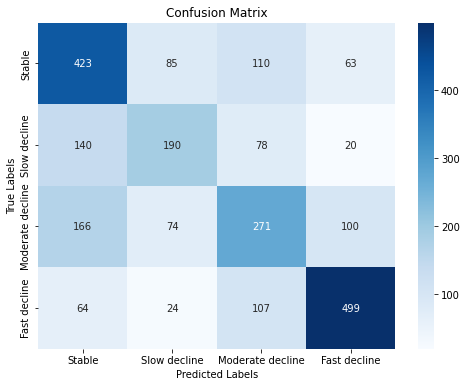

In [143]:
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Example true labels and predictions
y_true = df_filtered["Truth"]
y_pred = df_filtered["Prediction"]

# Define the class names
# Define the class names in the desired order, excluding 'Unknown'
desired_order = [ 'Stable','Slow decline', 'Moderate decline', 'Fast decline']
# Filter out 'Unknown' class from both true and predicted labels
mask = (y_true != 'Unknown.') & (y_pred != 'Unknown.')
y_true_filtered = y_true[mask]
y_pred_filtered = y_pred[mask]

# Compute the confusion matrix
cm = confusion_matrix(y_true_filtered, y_pred_filtered, labels=desired_order)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=desired_order, yticklabels=desired_order)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [144]:
# 初始化敏感性和特异性的列表
sensitivities = []
specificities = []
class_weights = []

# 遍历每个类别计算敏感性和特异性
for i in range(len(cm)):
    TP = cm[i, i]
    FN = np.sum(cm[i, :]) - TP
    FP = np.sum(cm[:, i]) - TP
    TN = np.sum(cm) - (TP + FN + FP)
    
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    
    sensitivities.append(sensitivity)
    specificities.append(specificity)
    
    # 权重为该类别的真实样本数
    class_weights.append(TP + FN)

# 计算加权平均敏感性和特异性
weighted_sensitivity = np.average(sensitivities, weights=class_weights)
weighted_specificity = np.average(specificities, weights=class_weights)

print(f"Weighted Sensitivity: {weighted_sensitivity:.4f}")
print(f"Weighted Specificity: {weighted_specificity:.4f}")

Weighted Sensitivity: 0.5729
Weighted Specificity: 0.8514


In [145]:
from sklearn.metrics import roc_auc_score
import pandas as pd

# Assuming MMSE is a pandas Series and filtered_df is a DataFrame

# Create a dictionary to store the AUC for each class
auc_scores = {}
cate=['Slow decline', 'Moderate decline', 'Fast decline', 'Stable']
class_weights = []


# Iterate through each class in filtered_df columns
for i,cls in enumerate(cate):
    # Convert MMSE to binary: 1 if the class matches, 0 otherwise
    binary_true_labels = ( df_filtered["Truth"]== cls).astype(int)
    
    # Get the predicted probabilities for the current class
    pred_probs = df_filtered.iloc[:,i+1]
    # Calculate the AUC for the current class
    auc_number = roc_auc_score(binary_true_labels, pred_probs)
    class_weights.append(sum(df_filtered["Truth"] == cls))
    # Store the AUC in the dictionary
    auc_scores[cls] = auc_number

# Convert the dictionary to a DataFrame for easier viewing
auc_df = pd.DataFrame.from_dict(auc_scores, orient='index', columns=['AUC'])
print(auc_df)


                       AUC
Slow decline      0.802521
Moderate decline  0.736482
Fast decline      0.895267
Stable            0.777886


In [146]:
weighted_auc = np.average(auc_df['AUC'], weights=class_weights)

In [147]:
weighted_auc

0.8055199361868284

## MMSE HABS-HD

In [148]:
result_habs=pd.read_csv("D:\\Research\\AD\\ADLLM\\ADNI process 9\\HABS-HD\\HABS-HD-results\\HABS_probability_MMSE.csv")

In [149]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score

# Assuming you have loaded your dataset in df
# df = pd.read_csv('your_dataset.csv')
df=result_habs
# Step 1: Rename the columns to remove the "Abeta-" prefixAbeta-Slow	Abeta-Moderate	Abeta-Fast	Abeta-Not decreasing
#MMSE-Slow	MMSE-Moderate	MMSE-Fast	MMSE-Not decreasing

df.rename(columns={
    'MMSE-Slow': 'Slow decline',
    'MMSE-Moderate': 'Moderate decline',
    'MMSE-Fast': 'Fast decline',
    'MMSE-Not decreasing':'Stable'
}, inplace=True)

# Step 2: Generate 'Prediction' column based on max probability
df['Prediction'] = df[['Slow decline', 'Moderate decline', 'Fast decline', 'Stable']].idxmax(axis=1)

# Step 3: Filter out rows where 'Truth' is 'Unknown'
df_filtered = df[df['Truth'] != 'Unknown.']
df_filtered

,Index,Slow decline,Moderate decline,Fast decline,Stable,Truth,Prediction
236,236,0.375056,0.424994,0.110866,0.089084,Moderate decline,Moderate decline
237,237,0.136046,0.735456,0.028966,0.099533,Moderate decline,Moderate decline
244,244,0.460936,0.311885,0.161804,0.065375,Moderate decline,Slow decline
245,245,0.000311,0.972377,0.023966,0.003346,Moderate decline,Moderate decline
246,246,0.582417,0.254439,0.087932,0.075212,Slow decline,Slow decline
...,...,...,...,...,...,...,...
737,737,0.774092,0.164814,0.032454,0.028640,Slow decline,Slow decline
738,738,0.104758,0.140967,0.049484,0.704791,Stable,Stable
739,739,0.032704,0.038234,0.002727,0.926335,Stable,Stable
740,740,0.283893,0.224578,0.065356,0.426174,Slow decline,Stable


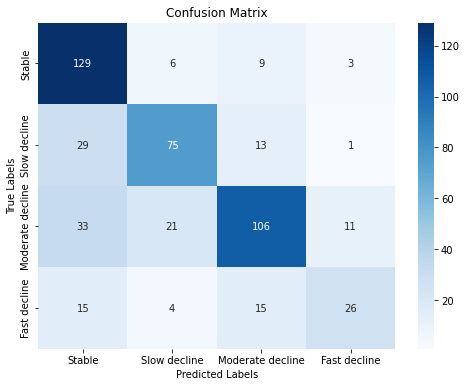

In [150]:
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Example true labels and predictions
y_true = df_filtered["Truth"]
y_pred = df_filtered["Prediction"]

# Define the class names
# Define the class names in the desired order, excluding 'Unknown'
desired_order = [ 'Stable','Slow decline', 'Moderate decline', 'Fast decline']
# Filter out 'Unknown' class from both true and predicted labels
mask = (y_true != 'Unknown.') & (y_pred != 'Unknown.')
y_true_filtered = y_true[mask]
y_pred_filtered = y_pred[mask]

# Compute the confusion matrix
cm = confusion_matrix(y_true_filtered, y_pred_filtered, labels=desired_order)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=desired_order, yticklabels=desired_order)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [151]:
# 初始化敏感性和特异性的列表
sensitivities = []
specificities = []
class_weights = []

# 遍历每个类别计算敏感性和特异性
for i in range(len(cm)):
    TP = cm[i, i]
    FN = np.sum(cm[i, :]) - TP
    FP = np.sum(cm[:, i]) - TP
    TN = np.sum(cm) - (TP + FN + FP)
    
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    
    sensitivities.append(sensitivity)
    specificities.append(specificity)
    
    # 权重为该类别的真实样本数
    class_weights.append(TP + FN)

# 计算加权平均敏感性和特异性
weighted_sensitivity = np.average(sensitivities, weights=class_weights)
weighted_specificity = np.average(specificities, weights=class_weights)

print(f"Weighted Sensitivity: {weighted_sensitivity:.4f}")
print(f"Weighted Specificity: {weighted_specificity:.4f}")

Weighted Sensitivity: 0.6774
Weighted Specificity: 0.8717


In [152]:
weighted_auc = np.average(auc_df['AUC'], weights=class_weights)

In [153]:
weighted_auc

0.8158050112697386

## MMSE binary

In [161]:

import pandas as pd
adni_mmse=pd.read_csv("D:\\Research\\AD\\ADLLM\\ADNI process 9\\ADNI\\ADNI-results\\ADNI_probability_MMSE.csv")
df=adni_mmse
df['Binary Truth'] = df['Truth'].apply(lambda x: 1 if 'stable' in x.lower() else 0)
# Redefining binary outcomes based on the sum of the probabilities for clearly positive and weakly positive
df['Not decreasing Probability'] = df['MMSE-Not decreasing'] 
df['Decreasing Probability'] = 1-df['MMSE-Not decreasing'] 

# Recalculating binary truth and binary prediction based on higher probability
df['Binary Prediction'] = df.apply(lambda x: 1 if x['Not decreasing Probability'] >= x['Decreasing Probability'] else 0, axis=1)

# Recalculate accuracy, specificity, and AUC
accuracy = accuracy_score(df['Binary Truth'], df['Binary Prediction'])
tn, fp, fn, tp = confusion_matrix(df['Binary Truth'], df['Binary Prediction']).ravel()
specificity = tn / (tn + fp)
auc = roc_auc_score(df['Binary Truth'], df['Not decreasing Probability'])

print(accuracy)

print(specificity)
print(auc)

0.7747564935064936
0.8816601233875491
0.7779888867201494


In [160]:
df["Truth"].value_counts()

Truth
Fast decline        694
Stable              681
Moderate decline    611
Slow decline        428
Unknown.             50
Name: count, dtype: int64

## HABS-MMSE

In [162]:

import pandas as pd
habs_mmse=pd.read_csv("D:\\Research\\AD\\ADLLM\\ADNI process 9\\HABS-HD\\HABS-HD-results\\HABS_probability_MMSE.csv")
df=habs_mmse
df['Binary Truth'] = df['Truth'].apply(lambda x: 1 if 'stable' in x.lower() else 0)
# Redefining binary outcomes based on the sum of the probabilities for clearly positive and weakly positive
df['Not decreasing Probability'] = df['MMSE-Not decreasing'] 
df['Decreasing Probability'] = 1-df['MMSE-Not decreasing'] 

# Recalculating binary truth and binary prediction based on higher probability
df['Binary Prediction'] = df.apply(lambda x: 1 if x['Not decreasing Probability'] >= x['Decreasing Probability'] else 0, axis=1)

# Recalculate accuracy, specificity, and AUC
accuracy = accuracy_score(df['Binary Truth'], df['Binary Prediction'])
tn, fp, fn, tp = confusion_matrix(df['Binary Truth'], df['Binary Prediction']).ravel()
specificity = tn / (tn + fp)
auc = roc_auc_score(df['Binary Truth'], df['Not decreasing Probability'])

print(accuracy)

print(specificity)
print(auc)

0.8382749326145552
0.8588235294117647
0.9039615846338536


## GB MMSE binary

In [3]:

import pandas as pd
adni_mmse=pd.read_csv("D:\\Research\\AD\\ADLLM\\ADNI process 9\\ADNI\\GB\\adni_testing_result_mmse.csv")
df=adni_mmse
df['Binary Truth'] = df['Truth'].apply(lambda x: 1 if 'zero' in x.lower() else 0)
# Redefining binary outcomes based on the sum of the probabilities for clearly positive and weakly positive
df['Not decreasing Probability'] = df['Zero'] 
df['Decreasing Probability'] = 1-df['Zero'] 

# Recalculating binary truth and binary prediction based on higher probability
df['Binary Prediction'] = df.apply(lambda x: 1 if x['Not decreasing Probability'] >= x['Decreasing Probability'] else 0, axis=1)

# Recalculate accuracy, specificity, and AUC
accuracy = accuracy_score(df['Binary Truth'], df['Binary Prediction'])
tn, fp, fn, tp = confusion_matrix(df['Binary Truth'], df['Binary Prediction']).ravel()
specificity = tn / (tn + fp)
auc = roc_auc_score(df['Binary Truth'], df['Not decreasing Probability'])

print(accuracy)

print(specificity)
print(auc)

0.7196377109921779
1.0
0.7016653393683404


In [4]:

import pandas as pd
habs_mmse=pd.read_csv("D:\\Research\\AD\\ADLLM\\ADNI process 9\\HABS-HD\\GB\\habs_testing_result_mmse.csv")
df=habs_mmse
df['Binary Truth'] = df['Truth'].apply(lambda x: 1 if 'zero' in x.lower() else 0)
# Redefining binary outcomes based on the sum of the probabilities for clearly positive and weakly positive
df['Not decreasing Probability'] = df['Zero'] 
df['Decreasing Probability'] = 1-df['Zero'] 

# Recalculating binary truth and binary prediction based on higher probability
df['Binary Prediction'] = df.apply(lambda x: 1 if x['Not decreasing Probability'] >= x['Decreasing Probability'] else 0, axis=1)

# Recalculate accuracy, specificity, and AUC
accuracy = accuracy_score(df['Binary Truth'], df['Binary Prediction'])
tn, fp, fn, tp = confusion_matrix(df['Binary Truth'], df['Binary Prediction']).ravel()
specificity = tn / (tn + fp)
auc = roc_auc_score(df['Binary Truth'], df['Not decreasing Probability'])

print(accuracy)

print(specificity)
print(auc)

0.7036290322580645
1.0
0.5987076779135724


In [5]:
confusion_matrix(df['Binary Truth'], df['Binary Prediction'])

array([[349,   0],
       [147,   0]], dtype=int64)

## Treatment

In [7]:
import pandas as pd
result_adni=pd.read_csv("D:\\Research\\AD\\ADLLM\\ADNI process 9\\ADNI\\ADNI-results\\ADNI_probability_treatment.csv")

In [8]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score

# Assuming you have loaded your dataset in df
# df = pd.read_csv('your_dataset.csv')
df=result_adni
# Step 1: Rename the columns to remove the "Abeta-" prefixAbeta-Slow	Abeta-Moderate	Abeta-Fast	Abeta-Not decreasing
#MMSE-Slow	MMSE-Moderate	MMSE-Fast	MMSE-Not decreasing

df.rename(columns={
    'Treatment-Ideal': 'ideal',
    'Treatment-Unlikely': 'unlikely'
}, inplace=True)

# Step 2: Generate 'Prediction' column based on max probability
df['Prediction'] = df[['ideal', 'unlikely']].idxmax(axis=1)

# Step 3: Filter out rows where 'Truth' is 'Unknown'
df_filtered = df[df['Truth'] != 'Unknown.']
df_filtered

,Index,ideal,unlikely,Truth,Prediction
98,98,5.614788e-04,0.999439,unlikely,unlikely
281,281,2.199534e-04,0.999780,unlikely,unlikely
283,283,3.682980e-04,0.999632,unlikely,unlikely
330,330,6.325933e-07,0.999999,unlikely,unlikely
342,342,0.000000e+00,1.000000,unlikely,unlikely
...,...,...,...,...,...
2457,2457,2.002738e-04,0.999800,unlikely,unlikely
2458,2458,0.000000e+00,1.000000,unlikely,unlikely
2459,2459,0.000000e+00,1.000000,unlikely,unlikely
2460,2460,3.187565e-06,0.999997,unlikely,unlikely


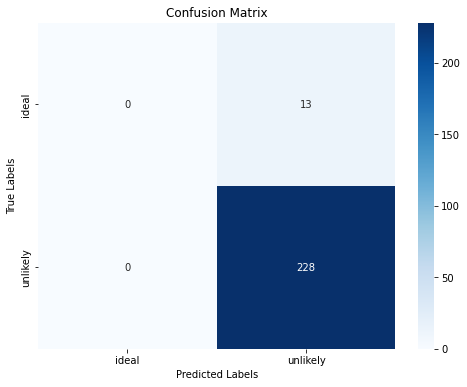

In [9]:
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Example true labels and predictions
y_true = df_filtered["Truth"]
y_pred = df_filtered["Prediction"]

# Define the class names
# Define the class names in the desired order, excluding 'Unknown'
desired_order = [ 'ideal','unlikely']
# Filter out 'Unknown' class from both true and predicted labels
mask = (y_true != 'Unknown.') & (y_pred != 'Unknown.')
y_true_filtered = y_true[mask]
y_pred_filtered = y_pred[mask]

# Compute the confusion matrix
cm = confusion_matrix(y_true_filtered, y_pred_filtered, labels=desired_order)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=desired_order, yticklabels=desired_order)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [10]:
# 初始化敏感性和特异性的列表
sensitivities = []
specificities = []
class_weights = []

# 遍历每个类别计算敏感性和特异性
for i in range(len(cm)):
    TP = cm[i, i]
    FN = np.sum(cm[i, :]) - TP
    FP = np.sum(cm[:, i]) - TP
    TN = np.sum(cm) - (TP + FN + FP)
    
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    
    sensitivities.append(sensitivity)
    specificities.append(specificity)
    
    # 权重为该类别的真实样本数
    class_weights.append(TP + FN)

# 计算加权平均敏感性和特异性
weighted_sensitivity = np.average(sensitivities, weights=class_weights)
weighted_specificity = np.average(specificities, weights=class_weights)

print(f"Weighted Sensitivity: {weighted_sensitivity:.4f}")
print(f"Weighted Specificity: {weighted_specificity:.4f}")

Weighted Sensitivity: 0.9461
Weighted Specificity: 0.0539


In [11]:
from sklearn.metrics import roc_auc_score
import pandas as pd

# Assuming MMSE is a pandas Series and filtered_df is a DataFrame

# Create a dictionary to store the AUC for each class
auc_scores = {}
cate=['ideal', 'unlikely']
class_weights = []


# Iterate through each class in filtered_df columns
for i,cls in enumerate(cate):
    # Convert MMSE to binary: 1 if the class matches, 0 otherwise
    binary_true_labels = ( df_filtered["Truth"]== cls).astype(int)
    
    # Get the predicted probabilities for the current class
    pred_probs = df_filtered.iloc[:,i+1]
    # Calculate the AUC for the current class
    auc_number = roc_auc_score(binary_true_labels, pred_probs)
    class_weights.append(sum(df_filtered["Truth"] == cls))
    # Store the AUC in the dictionary
    auc_scores[cls] = auc_number

# Convert the dictionary to a DataFrame for easier viewing
auc_df = pd.DataFrame.from_dict(auc_scores, orient='index', columns=['AUC'])
print(auc_df)


               AUC
ideal     0.537449
unlikely  0.537449


In [12]:
weighted_auc = np.average(auc_df['AUC'], weights=class_weights)

In [13]:
weighted_auc

0.5374493927125505

## HABS-Treatment

In [14]:
import pandas as pd
result_habs=pd.read_csv("D:\\Research\\AD\\ADLLM\\ADNI process 9\\HABS-HD\\HABS-HD-results\\HABS_probability_treatment.csv")

In [15]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score

# Assuming you have loaded your dataset in df
# df = pd.read_csv('your_dataset.csv')
df=result_habs
# Step 1: Rename the columns to remove the "Abeta-" prefixAbeta-Slow	Abeta-Moderate	Abeta-Fast	Abeta-Not decreasing
#MMSE-Slow	MMSE-Moderate	MMSE-Fast	MMSE-Not decreasing

df.rename(columns={
    'Treatment-Ideal': 'ideal',
    'Treatment-Unlikely': 'unlikely'
}, inplace=True)

# Step 2: Generate 'Prediction' column based on max probability
df['Prediction'] = df[['ideal', 'unlikely']].idxmax(axis=1)

# Step 3: Filter out rows where 'Truth' is 'Unknown'
df_filtered = df[df['Truth'] != 'Unknown.']
df_filtered

,Index,ideal,unlikely,Truth,Prediction
1,1,0.0,1.0,unlikely,unlikely
2,2,0.0,1.0,unlikely,unlikely
3,3,0.0,1.0,unlikely,unlikely
4,4,0.0,1.0,unlikely,unlikely
6,6,0.0,1.0,unlikely,unlikely
...,...,...,...,...,...
700,700,0.0,1.0,unlikely,unlikely
704,704,0.0,1.0,unlikely,unlikely
731,731,0.0,1.0,unlikely,unlikely
733,733,0.0,1.0,unlikely,unlikely


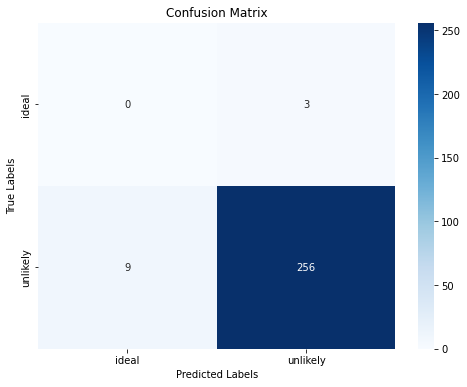

In [16]:
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Example true labels and predictions
y_true = df_filtered["Truth"]
y_pred = df_filtered["Prediction"]

# Define the class names
# Define the class names in the desired order, excluding 'Unknown'
desired_order = [ 'ideal','unlikely']
# Filter out 'Unknown' class from both true and predicted labels
mask = (y_true != 'Unknown.') & (y_pred != 'Unknown.')
y_true_filtered = y_true[mask]
y_pred_filtered = y_pred[mask]

# Compute the confusion matrix
cm = confusion_matrix(y_true_filtered, y_pred_filtered, labels=desired_order)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=desired_order, yticklabels=desired_order)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [17]:
# 初始化敏感性和特异性的列表
sensitivities = []
specificities = []
class_weights = []

# 遍历每个类别计算敏感性和特异性
for i in range(len(cm)):
    TP = cm[i, i]
    FN = np.sum(cm[i, :]) - TP
    FP = np.sum(cm[:, i]) - TP
    TN = np.sum(cm) - (TP + FN + FP)
    
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    
    sensitivities.append(sensitivity)
    specificities.append(specificity)
    
    # 权重为该类别的真实样本数
    class_weights.append(TP + FN)

# 计算加权平均敏感性和特异性
weighted_sensitivity = np.average(sensitivities, weights=class_weights)
weighted_specificity = np.average(specificities, weights=class_weights)

print(f"Weighted Sensitivity: {weighted_sensitivity:.4f}")
print(f"Weighted Specificity: {weighted_specificity:.4f}")

Weighted Sensitivity: 0.9552
Weighted Specificity: 0.0108


In [18]:
from sklearn.metrics import roc_auc_score
import pandas as pd

# Assuming MMSE is a pandas Series and filtered_df is a DataFrame

# Create a dictionary to store the AUC for each class
auc_scores = {}
cate=['ideal', 'unlikely']
class_weights = []


# Iterate through each class in filtered_df columns
for i,cls in enumerate(cate):
    # Convert MMSE to binary: 1 if the class matches, 0 otherwise
    binary_true_labels = ( df_filtered["Truth"]== cls).astype(int)
    
    # Get the predicted probabilities for the current class
    pred_probs = df_filtered.iloc[:,i+1]
    # Calculate the AUC for the current class
    auc_number = roc_auc_score(binary_true_labels, pred_probs)
    class_weights.append(sum(df_filtered["Truth"] == cls))
    # Store the AUC in the dictionary
    auc_scores[cls] = auc_number

# Convert the dictionary to a DataFrame for easier viewing
auc_df = pd.DataFrame.from_dict(auc_scores, orient='index', columns=['AUC'])
print(auc_df)


               AUC
ideal     0.437736
unlikely  0.437736


## Pointer-Treatment

In [21]:
import pandas as pd
result_pointer=pd.read_csv("D:\\Research\\AD\\ADLLM\\ADNI process 9\\POINTER\\POINTER-results\\POINTER_probability_treatment.csv")

In [22]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score

# Assuming you have loaded your dataset in df
# df = pd.read_csv('your_dataset.csv')
df=result_pointer
# Step 1: Rename the columns to remove the "Abeta-" prefixAbeta-Slow	Abeta-Moderate	Abeta-Fast	Abeta-Not decreasing
#MMSE-Slow	MMSE-Moderate	MMSE-Fast	MMSE-Not decreasing

df.rename(columns={
    'Treatment-Ideal': 'ideal',
    'Treatment-Unlikely': 'unlikely'
}, inplace=True)

# Step 2: Generate 'Prediction' column based on max probability
df['Prediction'] = df[['ideal', 'unlikely']].idxmax(axis=1)

# Step 3: Filter out rows where 'Truth' is 'Unknown'
df_filtered = df[df['Truth'] != 'Unknown.']
df_filtered

,Index,ideal,unlikely,Truth,Prediction
0,0,0.0,1.0,unlikely,unlikely
1,1,0.0,1.0,unlikely,unlikely
2,2,0.0,1.0,unlikely,unlikely
3,3,0.0,1.0,unlikely,unlikely
4,4,0.0,1.0,unlikely,unlikely
...,...,...,...,...,...
183,183,0.0,1.0,unlikely,unlikely
184,184,0.0,1.0,unlikely,unlikely
185,185,0.0,1.0,unlikely,unlikely
186,186,0.0,1.0,unlikely,unlikely


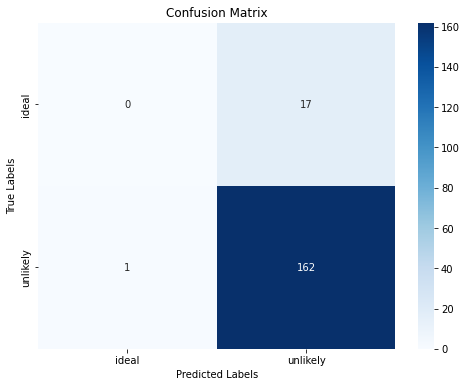

In [23]:
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Example true labels and predictions
y_true = df_filtered["Truth"]
y_pred = df_filtered["Prediction"]

# Define the class names
# Define the class names in the desired order, excluding 'Unknown'
desired_order = [ 'ideal','unlikely']
# Filter out 'Unknown' class from both true and predicted labels
mask = (y_true != 'Unknown.') & (y_pred != 'Unknown.')
y_true_filtered = y_true[mask]
y_pred_filtered = y_pred[mask]

# Compute the confusion matrix
cm = confusion_matrix(y_true_filtered, y_pred_filtered, labels=desired_order)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=desired_order, yticklabels=desired_order)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [24]:
# 初始化敏感性和特异性的列表
sensitivities = []
specificities = []
class_weights = []

# 遍历每个类别计算敏感性和特异性
for i in range(len(cm)):
    TP = cm[i, i]
    FN = np.sum(cm[i, :]) - TP
    FP = np.sum(cm[:, i]) - TP
    TN = np.sum(cm) - (TP + FN + FP)
    
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    
    sensitivities.append(sensitivity)
    specificities.append(specificity)
    
    # 权重为该类别的真实样本数
    class_weights.append(TP + FN)

# 计算加权平均敏感性和特异性
weighted_sensitivity = np.average(sensitivities, weights=class_weights)
weighted_specificity = np.average(specificities, weights=class_weights)

print(f"Weighted Sensitivity: {weighted_sensitivity:.4f}")
print(f"Weighted Specificity: {weighted_specificity:.4f}")

Weighted Sensitivity: 0.9000
Weighted Specificity: 0.0939


In [25]:
from sklearn.metrics import roc_auc_score
import pandas as pd

# Assuming MMSE is a pandas Series and filtered_df is a DataFrame

# Create a dictionary to store the AUC for each class
auc_scores = {}
cate=['ideal', 'unlikely']
class_weights = []


# Iterate through each class in filtered_df columns
for i,cls in enumerate(cate):
    # Convert MMSE to binary: 1 if the class matches, 0 otherwise
    binary_true_labels = ( df_filtered["Truth"]== cls).astype(int)
    
    # Get the predicted probabilities for the current class
    pred_probs = df_filtered.iloc[:,i+1]
    # Calculate the AUC for the current class
    auc_number = roc_auc_score(binary_true_labels, pred_probs)
    class_weights.append(sum(df_filtered["Truth"] == cls))
    # Store the AUC in the dictionary
    auc_scores[cls] = auc_number

# Convert the dictionary to a DataFrame for easier viewing
auc_df = pd.DataFrame.from_dict(auc_scores, orient='index', columns=['AUC'])
print(auc_df)


               AUC
ideal     0.500541
unlikely  0.500541


## A4-Treatment

In [28]:
import pandas as pd
result_a4=pd.read_csv("D:\\Research\\AD\\ADLLM\\ADNI process 9\\A4\\A4-results\\A4_probability_treatment.csv")

In [29]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score

# Assuming you have loaded your dataset in df
# df = pd.read_csv('your_dataset.csv')
df=result_a4
# Step 1: Rename the columns to remove the "Abeta-" prefixAbeta-Slow	Abeta-Moderate	Abeta-Fast	Abeta-Not decreasing
#MMSE-Slow	MMSE-Moderate	MMSE-Fast	MMSE-Not decreasing

df.rename(columns={
    'Treatment-Ideal': 'ideal',
    'Treatment-Unlikely': 'unlikely'
}, inplace=True)

# Step 2: Generate 'Prediction' column based on max probability
df['Prediction'] = df[['ideal', 'unlikely']].idxmax(axis=1)

# Step 3: Filter out rows where 'Truth' is 'Unknown'
df_filtered = df[df['Truth'] != 'Unknown.']
df_filtered

,Index,ideal,unlikely,Truth,Prediction
0,0,0.000007,0.999993,unlikely,unlikely
1,1,0.000000,1.000000,ideal,unlikely
2,2,0.000000,1.000000,unlikely,unlikely
3,3,0.000000,1.000000,unlikely,unlikely
4,4,0.000011,0.999989,unlikely,unlikely
...,...,...,...,...,...
435,435,0.000006,0.999994,unlikely,unlikely
436,436,0.000000,1.000000,unlikely,unlikely
437,437,0.000000,1.000000,unlikely,unlikely
438,438,0.000008,0.999992,unlikely,unlikely


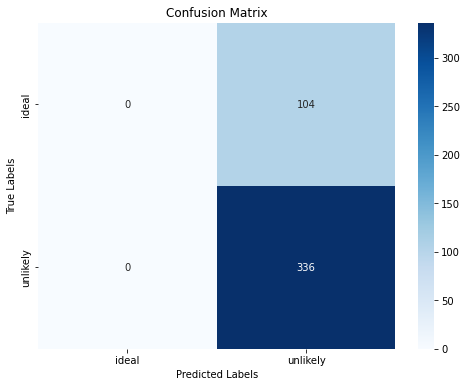

In [30]:
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Example true labels and predictions
y_true = df_filtered["Truth"]
y_pred = df_filtered["Prediction"]

# Define the class names
# Define the class names in the desired order, excluding 'Unknown'
desired_order = [ 'ideal','unlikely']
# Filter out 'Unknown' class from both true and predicted labels
mask = (y_true != 'Unknown.') & (y_pred != 'Unknown.')
y_true_filtered = y_true[mask]
y_pred_filtered = y_pred[mask]

# Compute the confusion matrix
cm = confusion_matrix(y_true_filtered, y_pred_filtered, labels=desired_order)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=desired_order, yticklabels=desired_order)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [31]:
# 初始化敏感性和特异性的列表
sensitivities = []
specificities = []
class_weights = []

# 遍历每个类别计算敏感性和特异性
for i in range(len(cm)):
    TP = cm[i, i]
    FN = np.sum(cm[i, :]) - TP
    FP = np.sum(cm[:, i]) - TP
    TN = np.sum(cm) - (TP + FN + FP)
    
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    
    sensitivities.append(sensitivity)
    specificities.append(specificity)
    
    # 权重为该类别的真实样本数
    class_weights.append(TP + FN)

# 计算加权平均敏感性和特异性
weighted_sensitivity = np.average(sensitivities, weights=class_weights)
weighted_specificity = np.average(specificities, weights=class_weights)

print(f"Weighted Sensitivity: {weighted_sensitivity:.4f}")
print(f"Weighted Specificity: {weighted_specificity:.4f}")

Weighted Sensitivity: 0.7636
Weighted Specificity: 0.2364


In [32]:
from sklearn.metrics import roc_auc_score
import pandas as pd

# Assuming MMSE is a pandas Series and filtered_df is a DataFrame

# Create a dictionary to store the AUC for each class
auc_scores = {}
cate=['ideal', 'unlikely']
class_weights = []


# Iterate through each class in filtered_df columns
for i,cls in enumerate(cate):
    # Convert MMSE to binary: 1 if the class matches, 0 otherwise
    binary_true_labels = ( df_filtered["Truth"]== cls).astype(int)
    
    # Get the predicted probabilities for the current class
    pred_probs = df_filtered.iloc[:,i+1]
    # Calculate the AUC for the current class
    auc_number = roc_auc_score(binary_true_labels, pred_probs)
    class_weights.append(sum(df_filtered["Truth"] == cls))
    # Store the AUC in the dictionary
    auc_scores[cls] = auc_number

# Convert the dictionary to a DataFrame for easier viewing
auc_df = pd.DataFrame.from_dict(auc_scores, orient='index', columns=['AUC'])
print(auc_df)


               AUC
ideal     0.484232
unlikely  0.484232


## Incomplete biomarkers

In [54]:
import pandas as pd
incomplete_index=pd.read_csv("D:\\Research\\AD\\ADLLM\\ADNI process 9\\ADNI\\index_complete.csv")

In [55]:
index_list=list(incomplete_index["Index"])

In [56]:
abeta_complete=pd.read_csv("D:\\Research\\AD\\ADLLM\\ADNI process 9\\ADNI\\ADNI-results\\ADNI_probability_abeta.csv")

In [57]:
abeta_complete_set=abeta_complete[abeta_complete["Index"].isin(index_list)]

In [58]:
abeta_complete_set

,Index,Abeta-Clearly positive,Abeta-Weakly positive,Abeta-Intermediate negative,Abeta-Negative,Truth
0,0,0.000000,0.000000,0.000000,0.000000,Unknown.
2,2,0.000000,0.000000,0.000000,0.000000,Unknown.
14,14,0.000000,0.000000,0.000000,0.000000,Unknown.
16,16,0.000000,0.000000,0.000000,0.000000,Unknown.
17,17,0.000000,0.000000,0.000000,0.000000,Unknown.
...,...,...,...,...,...,...
2430,2430,0.010652,0.015258,0.101061,0.873030,Negative
2433,2433,0.646189,0.125270,0.135449,0.093092,Clearly positive
2435,2435,0.345781,0.067033,0.107118,0.480069,Negative
2439,2439,0.000000,0.000000,0.000000,0.000000,Unknown.


In [59]:
abeta_incomplete=pd.read_csv("D:\\Research\\AD\\ADLLM\\ADNI process 9\\ADNI\\ADNI-results\\ADNI_probability_abeta_incomplete.csv")

In [60]:
abeta_incomplete_set=abeta_incomplete[abeta_incomplete["Index"].isin(index_list)]

In [61]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score

# Assuming you have loaded your dataset in df
# df = pd.read_csv('your_dataset.csv')
df=abeta_complete_set
# Step 1: Rename the columns to remove the "Abeta-" prefix
df.rename(columns={
    'Abeta-Clearly positive': 'Clearly positive',
    'Abeta-Weakly positive': 'Weakly positive',
    'Abeta-Intermediate negative': 'Intermediate negative',
    'Abeta-Negative': 'Negative'
}, inplace=True)

# Step 2: Generate 'Prediction' column based on max probability
df['Prediction'] = df[['Clearly positive', 'Weakly positive', 'Intermediate negative', 'Negative']].idxmax(axis=1)

# Step 3: Filter out rows where 'Truth' is 'Unknown'
df_filtered = df[df['Truth'] != 'Unknown.']
df_filtered

C:\Users\25110\AppData\Local\Temp/ipykernel_5184/2932129681.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={
C:\Users\25110\AppData\Local\Temp/ipykernel_5184/2932129681.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Prediction'] = df[['Clearly positive', 'Weakly positive', 'Intermediate negative', 'Negative']].idxmax(axis=1)


,Index,Clearly positive,Weakly positive,Intermediate negative,Negative,Truth,Prediction
39,39,0.159383,0.081405,0.167032,0.592180,Weakly positive,Negative
47,47,0.712471,0.116308,0.129751,0.041471,Weakly positive,Clearly positive
49,49,0.903025,0.059561,0.032893,0.004522,Clearly positive,Clearly positive
168,168,0.950561,0.033559,0.014210,0.001671,Clearly positive,Clearly positive
186,186,0.776160,0.097148,0.095642,0.031050,Clearly positive,Clearly positive
...,...,...,...,...,...,...,...
2417,2417,0.004382,0.005044,0.044260,0.946314,Negative,Negative
2430,2430,0.010652,0.015258,0.101061,0.873030,Negative,Negative
2433,2433,0.646189,0.125270,0.135449,0.093092,Clearly positive,Clearly positive
2435,2435,0.345781,0.067033,0.107118,0.480069,Negative,Negative


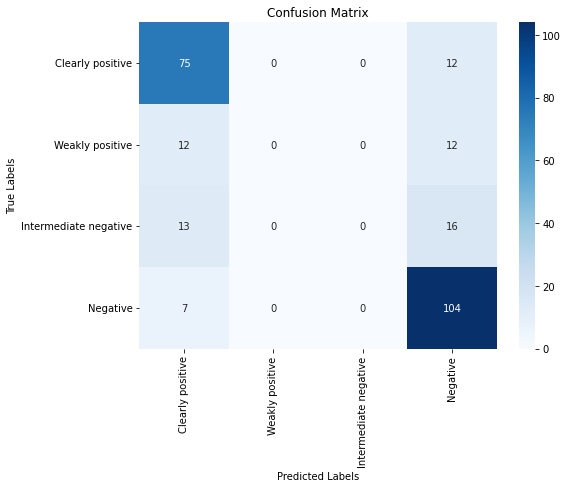

In [62]:
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Example true labels and predictions
y_true = df_filtered["Truth"]
y_pred = df_filtered["Prediction"]

# Define the class names
# Define the class names in the desired order, excluding 'Unknown'
desired_order = ['Clearly positive','Weakly positive','Intermediate negative','Negative']
# Filter out 'Unknown' class from both true and predicted labels
mask = (y_true != 'Unknown') & (y_pred != 'Unknown')
y_true_filtered = y_true[mask]
y_pred_filtered = y_pred[mask]

# Compute the confusion matrix
cm_complete = confusion_matrix(y_true_filtered, y_pred_filtered, labels=desired_order)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_complete , annot=True, fmt='d', cmap='Blues', xticklabels=desired_order, yticklabels=desired_order)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [74]:
(75+12)/(75+12+12+12)

0.7837837837837838

In [63]:
# 初始化敏感性和特异性的列表
sensitivities = []
specificities = []
class_weights = []

# 遍历每个类别计算敏感性和特异性
for i in range(len(cm_complete)):
    TP = cm_complete[i, i]
    FN = np.sum(cm_complete[i, :]) - TP
    FP = np.sum(cm_complete[:, i]) - TP
    TN = np.sum(cm_complete) - (TP + FN + FP)
    
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    
    sensitivities.append(sensitivity)
    specificities.append(specificity)
    
    # 权重为该类别的真实样本数
    class_weights.append(TP + FN)

# 计算加权平均敏感性和特异性
weighted_sensitivity = np.average(sensitivities, weights=class_weights)
weighted_specificity = np.average(specificities, weights=class_weights)

print(f"Weighted Sensitivity: {weighted_sensitivity:.4f}")
print(f"Weighted Specificity: {weighted_specificity:.4f}")

Weighted Sensitivity: 0.7131
Weighted Specificity: 0.8060


In [64]:
from sklearn.metrics import roc_auc_score
import pandas as pd

# Assuming MMSE is a pandas Series and filtered_df is a DataFrame

# Create a dictionary to store the AUC for each class
auc_scores = {}
cate= ["Clearly positive","Weakly positive","Intermediate negative","Negative"]
class_weights = []

# Iterate through each class in filtered_df columns
for i,cls in enumerate(cate):
    # Convert MMSE to binary: 1 if the class matches, 0 otherwise
    binary_true_labels = ( df_filtered["Truth"]== cls).astype(int)
    
    # Get the predicted probabilities for the current class
    pred_probs = df_filtered.iloc[:,i+1]
    
    # Calculate the AUC for the current class
    auc_number = roc_auc_score(binary_true_labels, pred_probs)
    class_weights.append(sum(df_filtered["Truth"] == cls))
    # Store the AUC in the dictionary
    auc_scores[cls] = auc_number

# Convert the dictionary to a DataFrame for easier viewing
auc_df = pd.DataFrame.from_dict(auc_scores, orient='index', columns=['AUC'])
print(auc_df)


                            AUC
Clearly positive       0.906995
Weakly positive        0.618392
Intermediate negative  0.649270
Negative               0.909717


In [65]:
weighted_auc = np.average(auc_df['AUC'], weights=class_weights)

In [66]:
weighted_auc

0.8508260818103429

In [67]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score

# Assuming you have loaded your dataset in df
# df = pd.read_csv('your_dataset.csv')
df=abeta_incomplete_set
# Step 1: Rename the columns to remove the "Abeta-" prefix
df.rename(columns={
    'Abeta-Clearly positive': 'Clearly positive',
    'Abeta-Weakly positive': 'Weakly positive',
    'Abeta-Intermediate negative': 'Intermediate negative',
    'Abeta-Negative': 'Negative'
}, inplace=True)

# Step 2: Generate 'Prediction' column based on max probability
df['Prediction'] = df[['Clearly positive', 'Weakly positive', 'Intermediate negative', 'Negative']].idxmax(axis=1)

# Step 3: Filter out rows where 'Truth' is 'Unknown'
df_filtered = df[df['Truth'] != 'Unknown.']
df_filtered

C:\Users\25110\AppData\Local\Temp/ipykernel_5184/1805204272.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={
C:\Users\25110\AppData\Local\Temp/ipykernel_5184/1805204272.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Prediction'] = df[['Clearly positive', 'Weakly positive', 'Intermediate negative', 'Negative']].idxmax(axis=1)


,Index,Clearly positive,Weakly positive,Intermediate negative,Negative,Truth,Prediction
39,39,0.105325,0.068003,0.129047,0.697624,Weakly positive,Negative
47,47,0.524660,0.115252,0.187073,0.173014,Weakly positive,Clearly positive
49,49,0.823024,0.061512,0.067558,0.047906,Clearly positive,Clearly positive
168,168,0.901264,0.062298,0.031325,0.005114,Clearly positive,Clearly positive
186,186,0.588895,0.117786,0.151241,0.142078,Clearly positive,Clearly positive
...,...,...,...,...,...,...,...
2417,2417,0.032375,0.031379,0.101292,0.834955,Negative,Negative
2430,2430,0.092504,0.066628,0.157354,0.683515,Negative,Negative
2433,2433,0.381909,0.095065,0.164257,0.358770,Clearly positive,Clearly positive
2435,2435,0.090491,0.047685,0.104154,0.757670,Negative,Negative


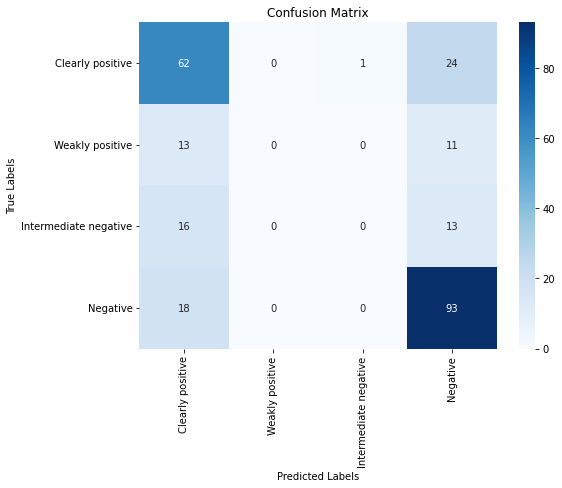

In [68]:
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Example true labels and predictions
y_true = df_filtered["Truth"]
y_pred = df_filtered["Prediction"]

# Define the class names
# Define the class names in the desired order, excluding 'Unknown'
desired_order = ['Clearly positive','Weakly positive','Intermediate negative','Negative']
# Filter out 'Unknown' class from both true and predicted labels
mask = (y_true != 'Unknown') & (y_pred != 'Unknown')
y_true_filtered = y_true[mask]
y_pred_filtered = y_pred[mask]

# Compute the confusion matrix
cm_complete = confusion_matrix(y_true_filtered, y_pred_filtered, labels=desired_order)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_complete , annot=True, fmt='d', cmap='Blues', xticklabels=desired_order, yticklabels=desired_order)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [73]:
(62+13)/(62+13+1+24+11)

0.6756756756756757

In [69]:
# 初始化敏感性和特异性的列表
sensitivities = []
specificities = []
class_weights = []

# 遍历每个类别计算敏感性和特异性
for i in range(len(cm_complete)):
    TP = cm_complete[i, i]
    FN = np.sum(cm_complete[i, :]) - TP
    FP = np.sum(cm_complete[:, i]) - TP
    TN = np.sum(cm_complete) - (TP + FN + FP)
    
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    
    sensitivities.append(sensitivity)
    specificities.append(specificity)
    
    # 权重为该类别的真实样本数
    class_weights.append(TP + FN)

# 计算加权平均敏感性和特异性
weighted_sensitivity = np.average(sensitivities, weights=class_weights)
weighted_specificity = np.average(specificities, weights=class_weights)

print(f"Weighted Sensitivity: {weighted_sensitivity:.4f}")
print(f"Weighted Specificity: {weighted_specificity:.4f}")

Weighted Sensitivity: 0.6175
Weighted Specificity: 0.7485


In [70]:
from sklearn.metrics import roc_auc_score
import pandas as pd

# Assuming MMSE is a pandas Series and filtered_df is a DataFrame

# Create a dictionary to store the AUC for each class
auc_scores = {}
cate= ["Clearly positive","Weakly positive","Intermediate negative","Negative"]
class_weights = []

# Iterate through each class in filtered_df columns
for i,cls in enumerate(cate):
    # Convert MMSE to binary: 1 if the class matches, 0 otherwise
    binary_true_labels = ( df_filtered["Truth"]== cls).astype(int)
    
    # Get the predicted probabilities for the current class
    pred_probs = df_filtered.iloc[:,i+1]
    
    # Calculate the AUC for the current class
    auc_number = roc_auc_score(binary_true_labels, pred_probs)
    class_weights.append(sum(df_filtered["Truth"] == cls))
    # Store the AUC in the dictionary
    auc_scores[cls] = auc_number

# Convert the dictionary to a DataFrame for easier viewing
auc_df = pd.DataFrame.from_dict(auc_scores, orient='index', columns=['AUC'])
print(auc_df)


                            AUC
Clearly positive       0.811396
Weakly positive        0.521476
Intermediate negative  0.602827
Negative               0.812677


In [71]:
weighted_auc = np.average(auc_df['AUC'], weights=class_weights)

In [72]:
weighted_auc

0.7601434532110025

## Incomplete HABS

In [75]:
import pandas as pd
incomplete_index=pd.read_csv("D:\\Research\\AD\\ADLLM\\ADNI process 9\\HABS-HD\\index_complete_habs.csv")

In [76]:
index_list=list(incomplete_index["Index"])

In [77]:
abeta_complete=pd.read_csv("D:\\Research\\AD\\ADLLM\\ADNI process 9\\HABS-HD\\HABS-HD-results\\HABS_probability_abeta.csv")

In [78]:
abeta_complete_set=abeta_complete[abeta_complete["Index"].isin(index_list)]

In [79]:
abeta_incomplete=pd.read_csv("D:\\Research\\AD\\ADLLM\\ADNI process 9\\HABS-HD\\HABS-HD-results\\HABS_probability_abeta_incomplete.csv")

In [80]:
abeta_incomplete_set=abeta_incomplete[abeta_incomplete["Index"].isin(index_list)]

In [81]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score

# Assuming you have loaded your dataset in df
# df = pd.read_csv('your_dataset.csv')
df=abeta_complete_set
# Step 1: Rename the columns to remove the "Abeta-" prefix
df.rename(columns={
    'Abeta-Clearly positive': 'Clearly positive',
    'Abeta-Weakly positive': 'Weakly positive',
    'Abeta-Intermediate negative': 'Intermediate negative',
    'Abeta-Negative': 'Negative'
}, inplace=True)

# Step 2: Generate 'Prediction' column based on max probability
df['Prediction'] = df[['Clearly positive', 'Weakly positive', 'Intermediate negative', 'Negative']].idxmax(axis=1)

# Step 3: Filter out rows where 'Truth' is 'Unknown'
df_filtered = df[df['Truth'] != 'Unknown.']
df_filtered

C:\Users\25110\AppData\Local\Temp/ipykernel_5184/2932129681.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={
C:\Users\25110\AppData\Local\Temp/ipykernel_5184/2932129681.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Prediction'] = df[['Clearly positive', 'Weakly positive', 'Intermediate negative', 'Negative']].idxmax(axis=1)


,Index,Clearly positive,Weakly positive,Intermediate negative,Negative,Truth,Prediction
0,0,0.038423,0.029003,0.098117,0.834457,Negative,Negative
1,1,0.019049,0.016040,0.075338,0.889572,Negative,Negative
2,2,0.017363,0.013523,0.064513,0.904601,Negative,Negative
3,3,0.021605,0.016055,0.071954,0.890386,Negative,Negative
4,4,0.017089,0.013102,0.065507,0.904302,Negative,Negative
...,...,...,...,...,...,...,...
229,229,0.028751,0.030605,0.087186,0.853458,Negative,Negative
232,232,0.030877,0.011720,0.055044,0.902359,Negative,Negative
312,312,0.024747,0.030320,0.099417,0.845516,Intermediate negative,Negative
457,457,0.152596,0.070964,0.172913,0.603527,Negative,Negative


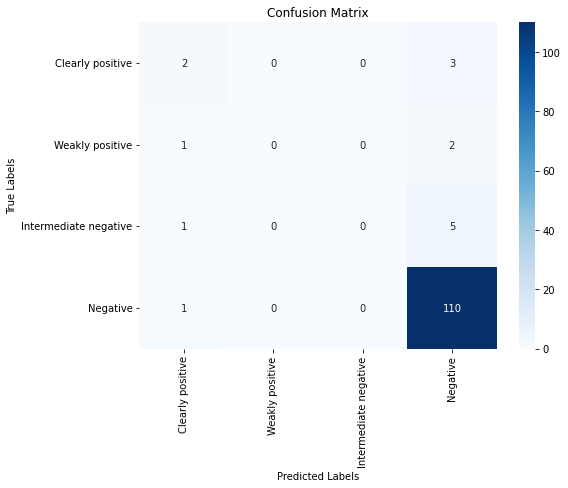

In [82]:
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Example true labels and predictions
y_true = df_filtered["Truth"]
y_pred = df_filtered["Prediction"]

# Define the class names
# Define the class names in the desired order, excluding 'Unknown'
desired_order = ['Clearly positive','Weakly positive','Intermediate negative','Negative']
# Filter out 'Unknown' class from both true and predicted labels
mask = (y_true != 'Unknown') & (y_pred != 'Unknown')
y_true_filtered = y_true[mask]
y_pred_filtered = y_pred[mask]

# Compute the confusion matrix
cm_complete = confusion_matrix(y_true_filtered, y_pred_filtered, labels=desired_order)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_complete , annot=True, fmt='d', cmap='Blues', xticklabels=desired_order, yticklabels=desired_order)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [93]:
3/(3+5)

0.375

In [83]:
# 初始化敏感性和特异性的列表
sensitivities = []
specificities = []
class_weights = []

# 遍历每个类别计算敏感性和特异性
for i in range(len(cm_complete)):
    TP = cm_complete[i, i]
    FN = np.sum(cm_complete[i, :]) - TP
    FP = np.sum(cm_complete[:, i]) - TP
    TN = np.sum(cm_complete) - (TP + FN + FP)
    
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    
    sensitivities.append(sensitivity)
    specificities.append(specificity)
    
    # 权重为该类别的真实样本数
    class_weights.append(TP + FN)

# 计算加权平均敏感性和特异性
weighted_sensitivity = np.average(sensitivities, weights=class_weights)
weighted_specificity = np.average(specificities, weights=class_weights)

print(f"Weighted Sensitivity: {weighted_sensitivity:.4f}")
print(f"Weighted Specificity: {weighted_specificity:.4f}")

Weighted Sensitivity: 0.8960
Weighted Specificity: 0.3647


In [84]:
from sklearn.metrics import roc_auc_score
import pandas as pd

# Assuming MMSE is a pandas Series and filtered_df is a DataFrame

# Create a dictionary to store the AUC for each class
auc_scores = {}
cate= ["Clearly positive","Weakly positive","Intermediate negative","Negative"]
class_weights = []

# Iterate through each class in filtered_df columns
for i,cls in enumerate(cate):
    # Convert MMSE to binary: 1 if the class matches, 0 otherwise
    binary_true_labels = ( df_filtered["Truth"]== cls).astype(int)
    
    # Get the predicted probabilities for the current class
    pred_probs = df_filtered.iloc[:,i+1]
    
    # Calculate the AUC for the current class
    auc_number = roc_auc_score(binary_true_labels, pred_probs)
    class_weights.append(sum(df_filtered["Truth"] == cls))
    # Store the AUC in the dictionary
    auc_scores[cls] = auc_number

# Convert the dictionary to a DataFrame for easier viewing
auc_df = pd.DataFrame.from_dict(auc_scores, orient='index', columns=['AUC'])
print(auc_df)


                            AUC
Clearly positive       0.890000
Weakly positive        0.830601
Intermediate negative  0.739496
Negative               0.866795


In [85]:
weighted_auc = np.average(auc_df['AUC'], weights=class_weights)

In [86]:
weighted_auc

0.8607445102631217

In [87]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score

# Assuming you have loaded your dataset in df
# df = pd.read_csv('your_dataset.csv')
df=abeta_incomplete_set
# Step 1: Rename the columns to remove the "Abeta-" prefix
df.rename(columns={
    'Abeta-Clearly positive': 'Clearly positive',
    'Abeta-Weakly positive': 'Weakly positive',
    'Abeta-Intermediate negative': 'Intermediate negative',
    'Abeta-Negative': 'Negative'
}, inplace=True)

# Step 2: Generate 'Prediction' column based on max probability
df['Prediction'] = df[['Clearly positive', 'Weakly positive', 'Intermediate negative', 'Negative']].idxmax(axis=1)

# Step 3: Filter out rows where 'Truth' is 'Unknown'
df_filtered = df[df['Truth'] != 'Unknown.']
df_filtered

C:\Users\25110\AppData\Local\Temp/ipykernel_5184/1805204272.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={
C:\Users\25110\AppData\Local\Temp/ipykernel_5184/1805204272.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Prediction'] = df[['Clearly positive', 'Weakly positive', 'Intermediate negative', 'Negative']].idxmax(axis=1)


,Index,Clearly positive,Weakly positive,Intermediate negative,Negative,Truth,Prediction
0,0,0.068658,0.039120,0.081533,0.810689,Negative,Negative
1,1,0.030148,0.015887,0.059028,0.894937,Negative,Negative
2,2,0.035774,0.022040,0.061812,0.880374,Negative,Negative
3,3,0.040662,0.020768,0.069169,0.869400,Negative,Negative
4,4,0.030368,0.017303,0.050857,0.901471,Negative,Negative
...,...,...,...,...,...,...,...
229,229,0.082679,0.037853,0.082679,0.796789,Negative,Negative
232,232,0.016390,0.005844,0.039938,0.937828,Negative,Negative
312,312,0.065442,0.039077,0.098239,0.797242,Intermediate negative,Negative
457,457,0.252021,0.076862,0.145859,0.525258,Negative,Negative


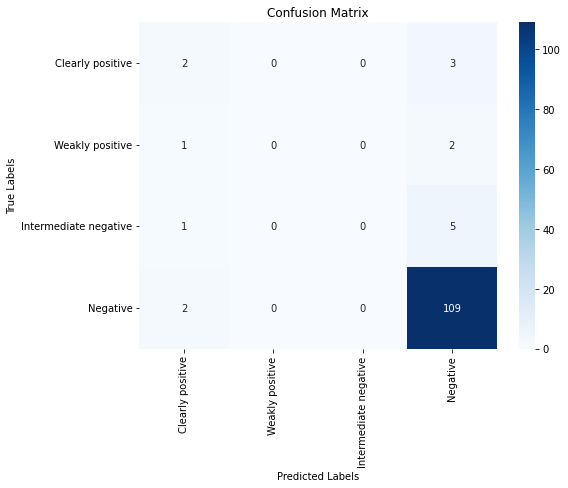

In [88]:
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Example true labels and predictions
y_true = df_filtered["Truth"]
y_pred = df_filtered["Prediction"]

# Define the class names
# Define the class names in the desired order, excluding 'Unknown'
desired_order = ['Clearly positive','Weakly positive','Intermediate negative','Negative']
# Filter out 'Unknown' class from both true and predicted labels
mask = (y_true != 'Unknown') & (y_pred != 'Unknown')
y_true_filtered = y_true[mask]
y_pred_filtered = y_pred[mask]

# Compute the confusion matrix
cm_complete = confusion_matrix(y_true_filtered, y_pred_filtered, labels=desired_order)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_complete , annot=True, fmt='d', cmap='Blues', xticklabels=desired_order, yticklabels=desired_order)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [89]:
# 初始化敏感性和特异性的列表
sensitivities = []
specificities = []
class_weights = []

# 遍历每个类别计算敏感性和特异性
for i in range(len(cm_complete)):
    TP = cm_complete[i, i]
    FN = np.sum(cm_complete[i, :]) - TP
    FP = np.sum(cm_complete[:, i]) - TP
    TN = np.sum(cm_complete) - (TP + FN + FP)
    
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    
    sensitivities.append(sensitivity)
    specificities.append(specificity)
    
    # 权重为该类别的真实样本数
    class_weights.append(TP + FN)

# 计算加权平均敏感性和特异性
weighted_sensitivity = np.average(sensitivities, weights=class_weights)
weighted_specificity = np.average(specificities, weights=class_weights)

print(f"Weighted Sensitivity: {weighted_sensitivity:.4f}")
print(f"Weighted Specificity: {weighted_specificity:.4f}")

Weighted Sensitivity: 0.8880
Weighted Specificity: 0.3644


In [90]:
from sklearn.metrics import roc_auc_score
import pandas as pd

# Assuming MMSE is a pandas Series and filtered_df is a DataFrame

# Create a dictionary to store the AUC for each class
auc_scores = {}
cate= ["Clearly positive","Weakly positive","Intermediate negative","Negative"]
class_weights = []

# Iterate through each class in filtered_df columns
for i,cls in enumerate(cate):
    # Convert MMSE to binary: 1 if the class matches, 0 otherwise
    binary_true_labels = ( df_filtered["Truth"]== cls).astype(int)
    
    # Get the predicted probabilities for the current class
    pred_probs = df_filtered.iloc[:,i+1]
    
    # Calculate the AUC for the current class
    auc_number = roc_auc_score(binary_true_labels, pred_probs)
    class_weights.append(sum(df_filtered["Truth"] == cls))
    # Store the AUC in the dictionary
    auc_scores[cls] = auc_number

# Convert the dictionary to a DataFrame for easier viewing
auc_df = pd.DataFrame.from_dict(auc_scores, orient='index', columns=['AUC'])
print(auc_df)


                            AUC
Clearly positive       0.895000
Weakly positive        0.833333
Intermediate negative  0.768908
Negative               0.861004


In [91]:
weighted_auc = np.average(auc_df['AUC'], weights=class_weights)

In [92]:
weighted_auc

0.8572789915966387

## Incomplete Meta tau ADNI

In [1]:
import pandas as pd
incomplete_index=pd.read_csv("D:\\Research\\AD\\ADLLM\\ADNI process 9\\ADNI\\index_complete.csv")
index_list=list(incomplete_index["Index"])
abeta_complete=pd.read_csv("D:\\Research\\AD\\ADLLM\\ADNI process 9\\ADNI\\ADNI-results\\ADNI_probability_meta_tau.csv")
abeta_complete_set=abeta_complete[abeta_complete["Index"].isin(index_list)]
abeta_incomplete=pd.read_csv("D:\\Research\\AD\\ADLLM\\ADNI process 9\\ADNI\\ADNI-results\\ADNI_probability_meta_tau_incomplete.csv")
abeta_incomplete_set=abeta_incomplete[abeta_incomplete["Index"].isin(index_list)]

D:\ANACONDA\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
D:\ANACONDA\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [20]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.utils     import resample

def prevalence_weighted_auc_bootstrap(df, truth_col, prob_cols, n_boot=2000, seed=0):
    """
    Parameters
    ----------
    df         : pd.DataFrame  – must contain `truth_col` and the prob columns
    truth_col  : str           – name of the truth-label column
    prob_cols  : list[str]     – four columns in the *same* order as CLASSES below
    n_boot     : int           – bootstrap replicates
    seed       : int           – RNG seed for reproducibility

    Returns
    -------
    auc_point  : float
    ci_low     : float
    ci_high    : float
    """
    CLASSES = ["Very low", "Low", "High", "Super high"]
    label_map = {c: i for i, c in enumerate(CLASSES)}

    # ------- drop rows with unknown / missing truth ---------------------
    df = df[df[truth_col].isin(CLASSES)].copy()
    if df.empty:
        raise ValueError("No valid rows after filtering.")

    y      = df[truth_col].map(label_map).to_numpy()
    scores = df[prob_cols].to_numpy()

    # ------- per-class AUCs --------------------------------------------
    aucs = [roc_auc_score((y == k).astype(int), scores[:, k])
            for k in range(len(CLASSES))]

    # ------- prevalence weights ----------------------------------------
    w        = np.bincount(y, minlength=len(CLASSES))
    w_auc    = np.average(aucs, weights=w)          # point estimate

    # ------- stratified bootstrap --------------------------------------
    rng   = np.random.default_rng(seed)
    boots = []
    for _ in range(n_boot):
        idx = resample(np.arange(len(y)),
                       replace=True,
                       stratify=y,
                       random_state=rng.integers(0, 1e9))
        y_b      = y[idx]
        scores_b = scores[idx]

        aucs_b = [roc_auc_score((y_b == k).astype(int), scores_b[:, k])
                  for k in range(len(CLASSES))]
        boots.append(np.average(aucs_b, weights=np.bincount(y_b,
                                                            minlength=len(CLASSES))))

    ci_low, ci_high = np.percentile(boots, [2.5, 97.5])
    return w_auc, ci_low, ci_high


# ---------------- example usage -----------------------------------------
# df = pd.read_csv("ADNI_probability_meta_tau.csv")
# prob_cols = ["Meta Tau-Very low", "Meta Tau-Low",
#              "Meta Tau-High",     "Meta Tau-Super high"]
# auc, lo, hi = prevalence_weighted_auc_bootstrap(df,
#                                                 truth_col="Truth",
#                                                 prob_cols=prob_cols,
#                                                 n_boot=2000)
# print(f"AUC = {auc:.3f}   95% CI = ({lo:.3f}, {hi:.3f})")
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
# Assuming you have loaded your dataset in df
# df = pd.read_csv('your_dataset.csv')
df=abeta_complete_set
# Step 1: Rename the columns to remove the "Abeta-" prefixAbeta-Slow	Abeta-Moderate	Abeta-Fast	Abeta-Not decreasing

df.rename(columns={
    'Meta Tau-Low': 'Low',
    'Meta Tau-Very low': 'Very low',
    'Meta Tau-Super high': 'Super high',
    'Meta Tau-High':'High'
}, inplace=True)

# # Step 2: Generate 'Prediction' column based on max probability
df['Prediction'] = df[['Very low', 'Low',  'High','Super high']].idxmax(axis=1)

# # Step 3: Filter out rows where 'Truth' is 'Unknown'
df_filtered = df[df['Truth'] != 'Unknown.']

result=prevalence_weighted_auc_bootstrap(df_filtered, "Truth", ["Very low", "Low", "High", "Super high"], n_boot=2000, seed=0)

C:\Users\25110\AppData\Local\Temp/ipykernel_14380/3913638395.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={
C:\Users\25110\AppData\Local\Temp/ipykernel_14380/3913638395.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Prediction'] = df[['Very low', 'Low',  'High','Super high']].idxmax(axis=1)


In [21]:
result

(0.7065921014891124, 0.6408343915075172, 0.7706237600688386)

In [17]:
df_filtered

,Index,Low,Very low,Super high,High,Truth,Prediction
595,595,0.132891,0.115458,0.525595,0.226056,Super high,Super high
860,860,0.245358,0.261182,0.142002,0.351459,Low,High
862,862,0.201428,0.279655,0.297691,0.221225,Low,Super high
1000,1000,0.113339,0.130453,0.593856,0.162351,Low,Super high
1163,1163,0.030224,0.024286,0.897192,0.048298,Super high,Super high
...,...,...,...,...,...,...,...
2417,2417,0.271129,0.327044,0.069632,0.332195,Very low,High
2430,2430,0.268801,0.286138,0.105264,0.339797,Very low,High
2433,2433,0.076832,0.081787,0.695580,0.145801,Super high,Super high
2435,2435,0.228141,0.316742,0.138374,0.316742,Low,Very low


C:\Users\25110\AppData\Local\Temp/ipykernel_14380/4013740698.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={
C:\Users\25110\AppData\Local\Temp/ipykernel_14380/4013740698.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Prediction'] = df[['Very low', 'Low',  'High','Super high']].idxmax(axis=1)


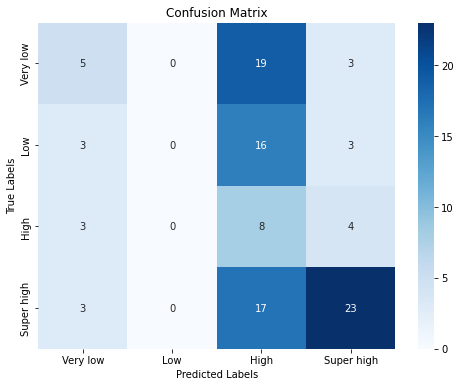

In [7]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
# Assuming you have loaded your dataset in df
# df = pd.read_csv('your_dataset.csv')
df=abeta_incomplete_set
# Step 1: Rename the columns to remove the "Abeta-" prefixAbeta-Slow	Abeta-Moderate	Abeta-Fast	Abeta-Not decreasing

df.rename(columns={
    'Meta Tau-Low': 'Low',
    'Meta Tau-Very low': 'Very low',
    'Meta Tau-Super high': 'Super high',
    'Meta Tau-High':'High'
}, inplace=True)

# # Step 2: Generate 'Prediction' column based on max probability
df['Prediction'] = df[['Very low', 'Low',  'High','Super high']].idxmax(axis=1)

# # Step 3: Filter out rows where 'Truth' is 'Unknown'
df_filtered = df[df['Truth'] != 'Unknown.']
df_filtered
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Example true labels and predictions
y_true = df_filtered["Truth"]
y_pred = df_filtered["Prediction"]

# Define the class names
# Define the class names in the desired order, excluding 'Unknown'
desired_order = ['Very low', 'Low',  'High','Super high']
# Filter out 'Unknown' class from both true and predicted labels
mask = (y_true != 'Unknown.') & (y_pred != 'Unknown.')
y_true_filtered = y_true[mask]
y_pred_filtered = y_pred[mask]

# Compute the confusion matrix
cm= confusion_matrix(y_true_filtered, y_pred_filtered, labels=desired_order)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=desired_order, yticklabels=desired_order)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [8]:
# 初始化敏感性和特异性的列表
sensitivities = []
specificities = []
class_weights = []

# 遍历每个类别计算敏感性和特异性
for i in range(len(cm)):
    TP = cm[i, i]
    FN = np.sum(cm[i, :]) - TP
    FP = np.sum(cm[:, i]) - TP
    TN = np.sum(cm) - (TP + FN + FP)
    
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    
    sensitivities.append(sensitivity)
    specificities.append(specificity)
    
    # 权重为该类别的真实样本数
    class_weights.append(TP + FN)

# 计算加权平均敏感性和特异性
weighted_sensitivity = np.average(sensitivities, weights=class_weights)
weighted_specificity = np.average(specificities, weights=class_weights)

print(f"Weighted Sensitivity: {weighted_sensitivity:.4f}")
print(f"Weighted Specificity: {weighted_specificity:.4f}")

Weighted Sensitivity: 0.3364
Weighted Specificity: 0.8296


In [9]:
from sklearn.metrics import roc_auc_score
import pandas as pd

# Assuming MMSE is a pandas Series and filtered_df is a DataFrame

# Create a dictionary to store the AUC for each class
auc_scores = {}
cate=["Low","Very low","Super high","High"]
class_weights = []

# Iterate through each class in filtered_df columns
for i,cls in enumerate(cate):
    # Convert MMSE to binary: 1 if the class matches, 0 otherwise
    binary_true_labels = ( df_filtered["Truth"]== cls).astype(int)
#     if i==0 or i==2 or i==3:
#         continue
    # Get the predicted probabilities for the current class
    pred_probs = df_filtered.iloc[:,i+1]
    
    # Calculate the AUC for the current class
    auc_number = roc_auc_score(binary_true_labels, pred_probs)
    class_weights.append(sum(df_filtered["Truth"] == cls))
    # Store the AUC in the dictionary
    auc_scores[cls] = auc_number

# Convert the dictionary to a DataFrame for easier viewing
auc_df = pd.DataFrame.from_dict(auc_scores, orient='index', columns=['AUC'])
print(auc_df)


                 AUC
Low         0.651872
Very low    0.700000
Super high  0.774346
High        0.562319


In [10]:
weighted_auc = np.average(auc_df['AUC'], weights=class_weights)

In [11]:
weighted_auc

0.7006806923297559

TypeError: process_pair() got an unexpected keyword argument 'full'

In [14]:
results

{}

C:\Users\25110\AppData\Local\Temp/ipykernel_5184/4013740698.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={
C:\Users\25110\AppData\Local\Temp/ipykernel_5184/4013740698.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Prediction'] = df[['Very low', 'Low',  'High','Super high']].idxmax(axis=1)


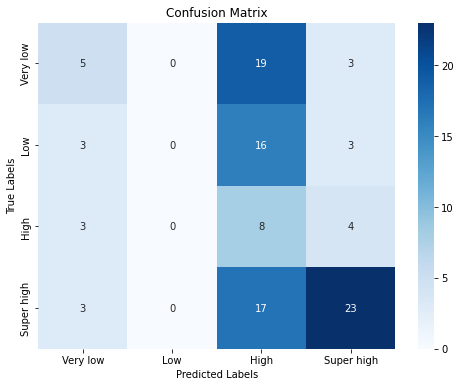

In [102]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
# Assuming you have loaded your dataset in df
# df = pd.read_csv('your_dataset.csv')
df=abeta_incomplete_set
# Step 1: Rename the columns to remove the "Abeta-" prefixAbeta-Slow	Abeta-Moderate	Abeta-Fast	Abeta-Not decreasing

df.rename(columns={
    'Meta Tau-Low': 'Low',
    'Meta Tau-Very low': 'Very low',
    'Meta Tau-Super high': 'Super high',
    'Meta Tau-High':'High'
}, inplace=True)

# # Step 2: Generate 'Prediction' column based on max probability
df['Prediction'] = df[['Very low', 'Low',  'High','Super high']].idxmax(axis=1)

# # Step 3: Filter out rows where 'Truth' is 'Unknown'
df_filtered = df[df['Truth'] != 'Unknown.']
df_filtered
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Example true labels and predictions
y_true = df_filtered["Truth"]
y_pred = df_filtered["Prediction"]

# Define the class names
# Define the class names in the desired order, excluding 'Unknown'
desired_order = ['Very low', 'Low',  'High','Super high']
# Filter out 'Unknown' class from both true and predicted labels
mask = (y_true != 'Unknown.') & (y_pred != 'Unknown.')
y_true_filtered = y_true[mask]
y_pred_filtered = y_pred[mask]

# Compute the confusion matrix
cm= confusion_matrix(y_true_filtered, y_pred_filtered, labels=desired_order)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=desired_order, yticklabels=desired_order)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [103]:
# 初始化敏感性和特异性的列表
sensitivities = []
specificities = []
class_weights = []

# 遍历每个类别计算敏感性和特异性
for i in range(len(cm)):
    TP = cm[i, i]
    FN = np.sum(cm[i, :]) - TP
    FP = np.sum(cm[:, i]) - TP
    TN = np.sum(cm) - (TP + FN + FP)
    
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    
    sensitivities.append(sensitivity)
    specificities.append(specificity)
    
    # 权重为该类别的真实样本数
    class_weights.append(TP + FN)

# 计算加权平均敏感性和特异性
weighted_sensitivity = np.average(sensitivities, weights=class_weights)
weighted_specificity = np.average(specificities, weights=class_weights)

print(f"Weighted Sensitivity: {weighted_sensitivity:.4f}")
print(f"Weighted Specificity: {weighted_specificity:.4f}")

Weighted Sensitivity: 0.3364
Weighted Specificity: 0.8296


In [104]:
from sklearn.metrics import roc_auc_score
import pandas as pd

# Assuming MMSE is a pandas Series and filtered_df is a DataFrame

# Create a dictionary to store the AUC for each class
auc_scores = {}
cate=["Low","Very low","Super high","High"]
class_weights = []

# Iterate through each class in filtered_df columns
for i,cls in enumerate(cate):
    # Convert MMSE to binary: 1 if the class matches, 0 otherwise
    binary_true_labels = ( df_filtered["Truth"]== cls).astype(int)
#     if i==0 or i==2 or i==3:
#         continue
    # Get the predicted probabilities for the current class
    pred_probs = df_filtered.iloc[:,i+1]
    
    # Calculate the AUC for the current class
    auc_number = roc_auc_score(binary_true_labels, pred_probs)
    class_weights.append(sum(df_filtered["Truth"] == cls))
    # Store the AUC in the dictionary
    auc_scores[cls] = auc_number

# Convert the dictionary to a DataFrame for easier viewing
auc_df = pd.DataFrame.from_dict(auc_scores, orient='index', columns=['AUC'])
print(auc_df)


                 AUC
Low         0.651872
Very low    0.700000
Super high  0.774346
High        0.562319


In [105]:
weighted_auc = np.average(auc_df['AUC'], weights=class_weights)

In [106]:
weighted_auc

0.7006806923297559

## Incomplete meta tau HABS

In [22]:
import pandas as pd
incomplete_index=pd.read_csv("D:\\Research\\AD\\ADLLM\\ADNI process 9\\HABS-HD\\index_complete_habs.csv")
index_list=list(incomplete_index["Index"])
abeta_complete=pd.read_csv("D:\\Research\\AD\\ADLLM\\ADNI process 9\\HABS-HD\\HABS-HD-results\\HABS_probability_meta_tau.csv")
abeta_complete_set=abeta_complete[abeta_complete["Index"].isin(index_list)]
abeta_incomplete=pd.read_csv("D:\\Research\\AD\\ADLLM\\ADNI process 9\\HABS-HD\\HABS-HD-results\\HABS_probability_meta_tau_incomplete.csv")
abeta_incomplete_set=abeta_incomplete[abeta_incomplete["Index"].isin(index_list)]

In [26]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.utils     import resample

def prevalence_weighted_auc_bootstrap(df, truth_col, prob_cols, n_boot=2000, seed=0):
    """
    Parameters
    ----------
    df         : pd.DataFrame  – must contain `truth_col` and the prob columns
    truth_col  : str           – name of the truth-label column
    prob_cols  : list[str]     – four columns in the *same* order as CLASSES below
    n_boot     : int           – bootstrap replicates
    seed       : int           – RNG seed for reproducibility

    Returns
    -------
    auc_point  : float
    ci_low     : float
    ci_high    : float
    """
    CLASSES = ["Very low", "Low", "High", "Super high"]
    label_map = {c: i for i, c in enumerate(CLASSES)}

    # ------- drop rows with unknown / missing truth ---------------------
    df = df[df[truth_col].isin(CLASSES)].copy()
    if df.empty:
        raise ValueError("No valid rows after filtering.")

    y      = df[truth_col].map(label_map).to_numpy()
    scores = df[prob_cols].to_numpy()

    # ------- per-class AUCs --------------------------------------------
    aucs = [roc_auc_score((y == k).astype(int), scores[:, k])
            for k in range(len(CLASSES))]

    # ------- prevalence weights ----------------------------------------
    w        = np.bincount(y, minlength=len(CLASSES))
    w_auc    = np.average(aucs, weights=w)          # point estimate

    # ------- stratified bootstrap --------------------------------------
    rng   = np.random.default_rng(seed)
    boots = []
    for _ in range(n_boot):
        idx = resample(np.arange(len(y)),
                       replace=True,
                       stratify=y,
                       random_state=rng.integers(0, 1e9))
        y_b      = y[idx]
        scores_b = scores[idx]

        aucs_b = [roc_auc_score((y_b == k).astype(int), scores_b[:, k])
                  for k in range(len(CLASSES))]
        boots.append(np.average(aucs_b, weights=np.bincount(y_b,
                                                            minlength=len(CLASSES))))

    ci_low, ci_high = np.percentile(boots, [2.5, 97.5])
    return w_auc, ci_low, ci_high


# ---------------- example usage -----------------------------------------
# df = pd.read_csv("ADNI_probability_meta_tau.csv")
# prob_cols = ["Meta Tau-Very low", "Meta Tau-Low",
#              "Meta Tau-High",     "Meta Tau-Super high"]
# auc, lo, hi = prevalence_weighted_auc_bootstrap(df,
#                                                 truth_col="Truth",
#                                                 prob_cols=prob_cols,
#                                                 n_boot=2000)
# print(f"AUC = {auc:.3f}   95% CI = ({lo:.3f}, {hi:.3f})")
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
# Assuming you have loaded your dataset in df
# df = pd.read_csv('your_dataset.csv')
df=abeta_incomplete_set
# Step 1: Rename the columns to remove the "Abeta-" prefixAbeta-Slow	Abeta-Moderate	Abeta-Fast	Abeta-Not decreasing

df.rename(columns={
    'Meta Tau-Low': 'Low',
    'Meta Tau-Very low': 'Very low',
    'Meta Tau-Super high': 'Super high',
    'Meta Tau-High':'High'
}, inplace=True)

# # Step 2: Generate 'Prediction' column based on max probability
df['Prediction'] = df[['Very low', 'Low',  'High','Super high']].idxmax(axis=1)

# # Step 3: Filter out rows where 'Truth' is 'Unknown'
df_filtered = df[df['Truth'] != 'Unknown.']

result=prevalence_weighted_auc_bootstrap(df_filtered, "Truth", ["Very low", "Low", "High", "Super high"], n_boot=2000, seed=0)

C:\Users\25110\AppData\Local\Temp/ipykernel_14380/2331423175.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={
C:\Users\25110\AppData\Local\Temp/ipykernel_14380/2331423175.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Prediction'] = df[['Very low', 'Low',  'High','Super high']].idxmax(axis=1)


In [27]:
result

(0.6017975392255309, 0.5179438169185158, 0.6809116906904286)

C:\Users\25110\AppData\Local\Temp/ipykernel_14380/3911912401.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={
C:\Users\25110\AppData\Local\Temp/ipykernel_14380/3911912401.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Prediction'] = df[['Very low', 'Low',  'High','Super high']].idxmax(axis=1)


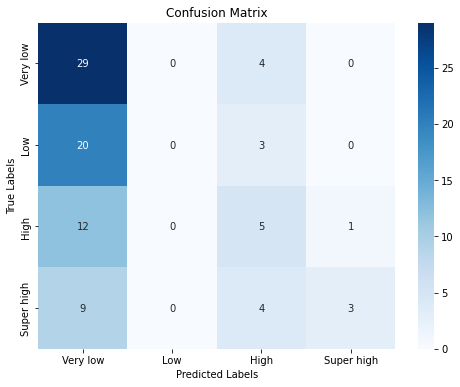

In [23]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
# Assuming you have loaded your dataset in df
# df = pd.read_csv('your_dataset.csv')
df=abeta_complete_set
# Step 1: Rename the columns to remove the "Abeta-" prefixAbeta-Slow	Abeta-Moderate	Abeta-Fast	Abeta-Not decreasing

df.rename(columns={
    'Meta Tau-Low': 'Low',
    'Meta Tau-Very low': 'Very low',
    'Meta Tau-Super high': 'Super high',
    'Meta Tau-High':'High'
}, inplace=True)

# # Step 2: Generate 'Prediction' column based on max probability
df['Prediction'] = df[['Very low', 'Low',  'High','Super high']].idxmax(axis=1)

# # Step 3: Filter out rows where 'Truth' is 'Unknown'
df_filtered = df[df['Truth'] != 'Unknown.']
df_filtered
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Example true labels and predictions
y_true = df_filtered["Truth"]
y_pred = df_filtered["Prediction"]

# Define the class names
# Define the class names in the desired order, excluding 'Unknown'
desired_order = ['Very low', 'Low',  'High','Super high']
# Filter out 'Unknown' class from both true and predicted labels
mask = (y_true != 'Unknown.') & (y_pred != 'Unknown.')
y_true_filtered = y_true[mask]
y_pred_filtered = y_pred[mask]

# Compute the confusion matrix
cm= confusion_matrix(y_true_filtered, y_pred_filtered, labels=desired_order)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=desired_order, yticklabels=desired_order)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [116]:
# 初始化敏感性和特异性的列表
sensitivities = []
specificities = []
class_weights = []

# 遍历每个类别计算敏感性和特异性
for i in range(len(cm)):
    TP = cm[i, i]
    FN = np.sum(cm[i, :]) - TP
    FP = np.sum(cm[:, i]) - TP
    TN = np.sum(cm) - (TP + FN + FP)
    
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    
    sensitivities.append(sensitivity)
    specificities.append(specificity)
    
    # 权重为该类别的真实样本数
    class_weights.append(TP + FN)

# 计算加权平均敏感性和特异性
weighted_sensitivity = np.average(sensitivities, weights=class_weights)
weighted_specificity = np.average(specificities, weights=class_weights)

print(f"Weighted Sensitivity: {weighted_sensitivity:.4f}")
print(f"Weighted Specificity: {weighted_specificity:.4f}")

Weighted Sensitivity: 0.4111
Weighted Specificity: 0.7033


In [117]:
from sklearn.metrics import roc_auc_score
import pandas as pd

# Assuming MMSE is a pandas Series and filtered_df is a DataFrame

# Create a dictionary to store the AUC for each class
auc_scores = {}
cate=["Low","Very low","Super high","High"]
class_weights = []

# Iterate through each class in filtered_df columns
for i,cls in enumerate(cate):
    # Convert MMSE to binary: 1 if the class matches, 0 otherwise
    binary_true_labels = ( df_filtered["Truth"]== cls).astype(int)
#     if i==0 or i==2 or i==3:
#         continue
    # Get the predicted probabilities for the current class
    pred_probs = df_filtered.iloc[:,i+1]
    
    # Calculate the AUC for the current class
    auc_number = roc_auc_score(binary_true_labels, pred_probs)
    class_weights.append(sum(df_filtered["Truth"] == cls))
    # Store the AUC in the dictionary
    auc_scores[cls] = auc_number

# Convert the dictionary to a DataFrame for easier viewing
auc_df = pd.DataFrame.from_dict(auc_scores, orient='index', columns=['AUC'])
print(auc_df)


                 AUC
Low         0.492537
Very low    0.636364
Super high  0.602196
High        0.545525


In [118]:
weighted_auc = np.average(auc_df['AUC'], weights=class_weights)

In [119]:
weighted_auc

0.5753659754281645

C:\Users\25110\AppData\Local\Temp/ipykernel_5184/4013740698.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={
C:\Users\25110\AppData\Local\Temp/ipykernel_5184/4013740698.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Prediction'] = df[['Very low', 'Low',  'High','Super high']].idxmax(axis=1)


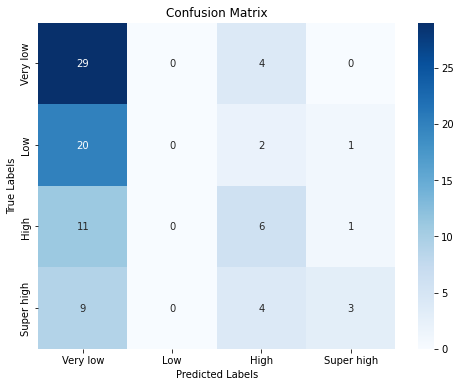

In [120]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
# Assuming you have loaded your dataset in df
# df = pd.read_csv('your_dataset.csv')
df=abeta_incomplete_set
# Step 1: Rename the columns to remove the "Abeta-" prefixAbeta-Slow	Abeta-Moderate	Abeta-Fast	Abeta-Not decreasing

df.rename(columns={
    'Meta Tau-Low': 'Low',
    'Meta Tau-Very low': 'Very low',
    'Meta Tau-Super high': 'Super high',
    'Meta Tau-High':'High'
}, inplace=True)

# # Step 2: Generate 'Prediction' column based on max probability
df['Prediction'] = df[['Very low', 'Low',  'High','Super high']].idxmax(axis=1)

# # Step 3: Filter out rows where 'Truth' is 'Unknown'
df_filtered = df[df['Truth'] != 'Unknown.']
df_filtered
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Example true labels and predictions
y_true = df_filtered["Truth"]
y_pred = df_filtered["Prediction"]

# Define the class names
# Define the class names in the desired order, excluding 'Unknown'
desired_order = ['Very low', 'Low',  'High','Super high']
# Filter out 'Unknown' class from both true and predicted labels
mask = (y_true != 'Unknown.') & (y_pred != 'Unknown.')
y_true_filtered = y_true[mask]
y_pred_filtered = y_pred[mask]

# Compute the confusion matrix
cm= confusion_matrix(y_true_filtered, y_pred_filtered, labels=desired_order)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=desired_order, yticklabels=desired_order)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [121]:
# 初始化敏感性和特异性的列表
sensitivities = []
specificities = []
class_weights = []

# 遍历每个类别计算敏感性和特异性
for i in range(len(cm)):
    TP = cm[i, i]
    FN = np.sum(cm[i, :]) - TP
    FP = np.sum(cm[:, i]) - TP
    TN = np.sum(cm) - (TP + FN + FP)
    
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    
    sensitivities.append(sensitivity)
    specificities.append(specificity)
    
    # 权重为该类别的真实样本数
    class_weights.append(TP + FN)

# 计算加权平均敏感性和特异性
weighted_sensitivity = np.average(sensitivities, weights=class_weights)
weighted_specificity = np.average(specificities, weights=class_weights)

print(f"Weighted Sensitivity: {weighted_sensitivity:.4f}")
print(f"Weighted Specificity: {weighted_specificity:.4f}")

Weighted Sensitivity: 0.4222
Weighted Specificity: 0.7101


In [122]:
from sklearn.metrics import roc_auc_score
import pandas as pd

# Assuming MMSE is a pandas Series and filtered_df is a DataFrame

# Create a dictionary to store the AUC for each class
auc_scores = {}
cate=["Low","Very low","Super high","High"]
class_weights = []

# Iterate through each class in filtered_df columns
for i,cls in enumerate(cate):
    # Convert MMSE to binary: 1 if the class matches, 0 otherwise
    binary_true_labels = ( df_filtered["Truth"]== cls).astype(int)
#     if i==0 or i==2 or i==3:
#         continue
    # Get the predicted probabilities for the current class
    pred_probs = df_filtered.iloc[:,i+1]
    
    # Calculate the AUC for the current class
    auc_number = roc_auc_score(binary_true_labels, pred_probs)
    class_weights.append(sum(df_filtered["Truth"] == cls))
    # Store the AUC in the dictionary
    auc_scores[cls] = auc_number

# Convert the dictionary to a DataFrame for easier viewing
auc_df = pd.DataFrame.from_dict(auc_scores, orient='index', columns=['AUC'])
print(auc_df)


                 AUC
Low         0.546398
Very low    0.624136
Super high  0.629223
High        0.607253


In [123]:
weighted_auc = np.average(auc_df['AUC'], weights=class_weights)

In [124]:
weighted_auc

0.6017975392255309

### MMSE visit times

1
462


C:\Users\25110\AppData\Local\Temp/ipykernel_5184/2757640877.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={
C:\Users\25110\AppData\Local\Temp/ipykernel_5184/2757640877.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Prediction'] = df[['Slow decline', 'Moderate decline', 'Fast decline', 'Stable']].idxmax(axis=1)


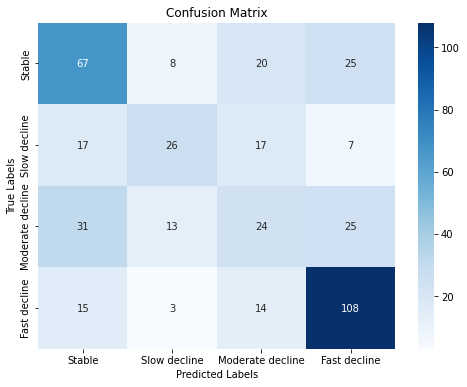

Weighted Sensitivity: 0.5357
Weighted Specificity: 0.8268
                       AUC
Slow decline      0.802038
Moderate decline  0.638716
Fast decline      0.852423
Stable            0.724306
0.7604597807407046
2
428


C:\Users\25110\AppData\Local\Temp/ipykernel_5184/2757640877.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={
C:\Users\25110\AppData\Local\Temp/ipykernel_5184/2757640877.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Prediction'] = df[['Slow decline', 'Moderate decline', 'Fast decline', 'Stable']].idxmax(axis=1)


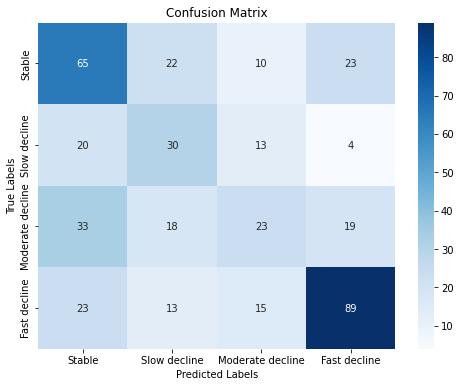

C:\Users\25110\AppData\Local\Temp/ipykernel_5184/2757640877.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={
C:\Users\25110\AppData\Local\Temp/ipykernel_5184/2757640877.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Prediction'] = df[['Slow decline', 'Moderate decline', 'Fast decline', 'Stable']].idxmax(axis=1)


Weighted Sensitivity: 0.4929
Weighted Specificity: 0.8232
                       AUC
Slow decline      0.787620
Moderate decline  0.662984
Fast decline      0.808903
Stable            0.674361
0.7347566488169714
3
372


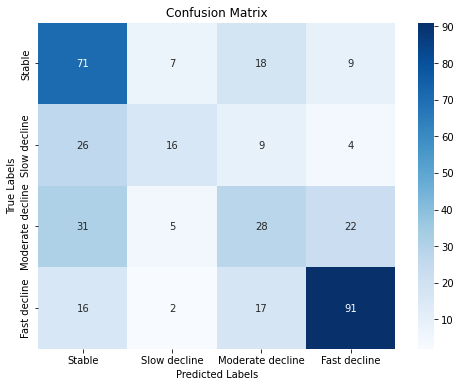

C:\Users\25110\AppData\Local\Temp/ipykernel_5184/2757640877.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={
C:\Users\25110\AppData\Local\Temp/ipykernel_5184/2757640877.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Prediction'] = df[['Slow decline', 'Moderate decline', 'Fast decline', 'Stable']].idxmax(axis=1)


Weighted Sensitivity: 0.5538
Weighted Specificity: 0.8325
                       AUC
Slow decline      0.824606
Moderate decline  0.692267
Fast decline      0.888082
Stable            0.775887
0.8017602583751384
4
312


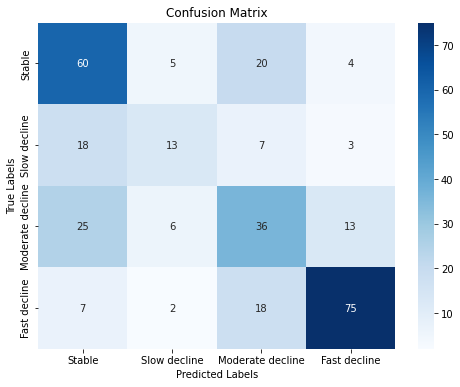

C:\Users\25110\AppData\Local\Temp/ipykernel_5184/2757640877.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={
C:\Users\25110\AppData\Local\Temp/ipykernel_5184/2757640877.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Prediction'] = df[['Slow decline', 'Moderate decline', 'Fast decline', 'Stable']].idxmax(axis=1)


Weighted Sensitivity: 0.5897
Weighted Specificity: 0.8489
                       AUC
Slow decline      0.807398
Moderate decline  0.722953
Fast decline      0.910994
Stable            0.819041
0.822934536330998
5
239


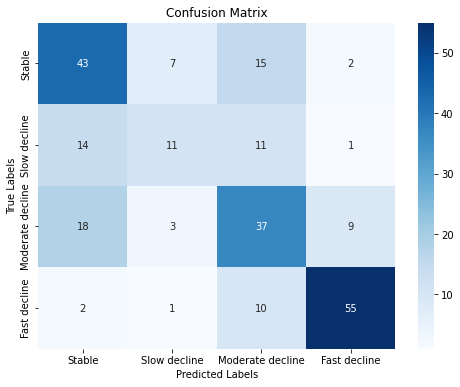

C:\Users\25110\AppData\Local\Temp/ipykernel_5184/2757640877.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={
C:\Users\25110\AppData\Local\Temp/ipykernel_5184/2757640877.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Prediction'] = df[['Slow decline', 'Moderate decline', 'Fast decline', 'Stable']].idxmax(axis=1)


Weighted Sensitivity: 0.6109
Weighted Specificity: 0.8575
                       AUC
Slow decline      0.760637
Moderate decline  0.716505
Fast decline      0.933093
Stable            0.809875
0.8111351406467011
6
193


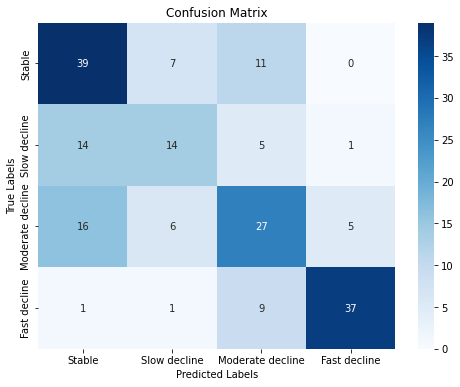

C:\Users\25110\AppData\Local\Temp/ipykernel_5184/2757640877.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={
C:\Users\25110\AppData\Local\Temp/ipykernel_5184/2757640877.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Prediction'] = df[['Slow decline', 'Moderate decline', 'Fast decline', 'Stable']].idxmax(axis=1)


Weighted Sensitivity: 0.6062
Weighted Specificity: 0.8566
                       AUC
Slow decline      0.720126
Moderate decline  0.778444
Fast decline      0.953879
Stable            0.847781
0.8322797111963613
7
140


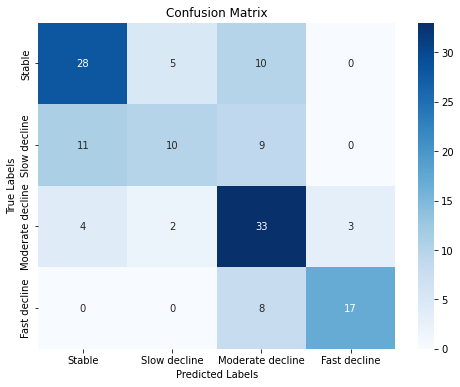

Weighted Sensitivity: 0.6286
Weighted Specificity: 0.8516
                       AUC
Slow decline      0.837121
Moderate decline  0.829446
Fast decline      0.955826
Stable            0.837329
0.856079841932873
8
101


C:\Users\25110\AppData\Local\Temp/ipykernel_5184/2757640877.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={
C:\Users\25110\AppData\Local\Temp/ipykernel_5184/2757640877.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Prediction'] = df[['Slow decline', 'Moderate decline', 'Fast decline', 'Stable']].idxmax(axis=1)


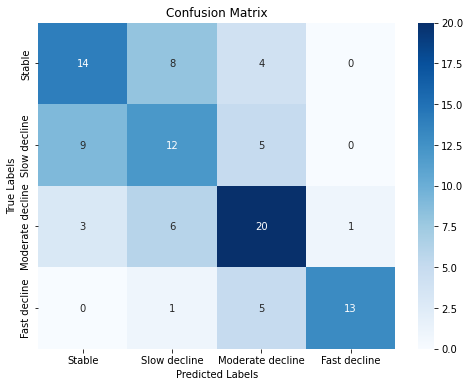

C:\Users\25110\AppData\Local\Temp/ipykernel_5184/2757640877.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={
C:\Users\25110\AppData\Local\Temp/ipykernel_5184/2757640877.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Prediction'] = df[['Slow decline', 'Moderate decline', 'Fast decline', 'Stable']].idxmax(axis=1)


Weighted Sensitivity: 0.5842
Weighted Specificity: 0.8465
                       AUC
Slow decline      0.779487
Moderate decline  0.823944
Fast decline      0.922336
Stable            0.826154
0.8315778888091488
9
69


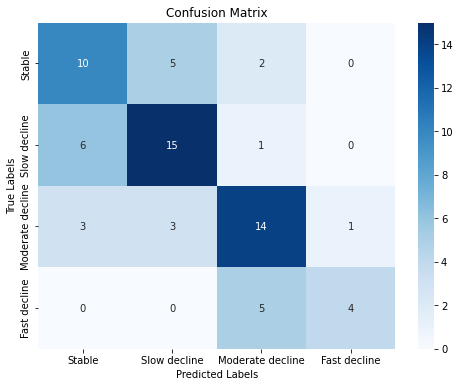

C:\Users\25110\AppData\Local\Temp/ipykernel_5184/2757640877.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={
C:\Users\25110\AppData\Local\Temp/ipykernel_5184/2757640877.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Prediction'] = df[['Slow decline', 'Moderate decline', 'Fast decline', 'Stable']].idxmax(axis=1)


Weighted Sensitivity: 0.6232
Weighted Specificity: 0.8502
                       AUC
Slow decline      0.849613
Moderate decline  0.762401
Fast decline      0.962963
Stable            0.755656
0.8147061817563668
10
55


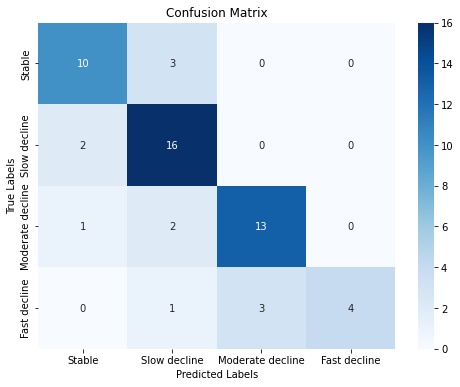

Weighted Sensitivity: 0.7818
Weighted Specificity: 0.9077
                       AUC
Slow decline      0.912913
Moderate decline  0.891026
Fast decline      0.856383
Stable            0.879121
0.8903359626763884
11
38


C:\Users\25110\AppData\Local\Temp/ipykernel_5184/2757640877.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={
C:\Users\25110\AppData\Local\Temp/ipykernel_5184/2757640877.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Prediction'] = df[['Slow decline', 'Moderate decline', 'Fast decline', 'Stable']].idxmax(axis=1)


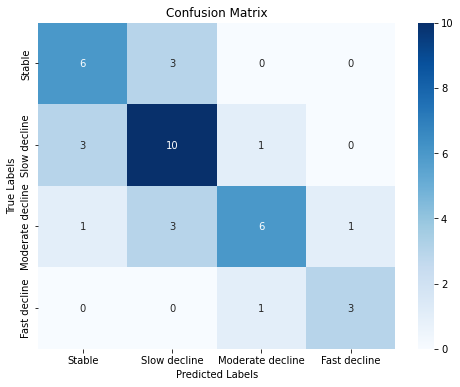

Weighted Sensitivity: 0.6579
Weighted Specificity: 0.8507
                       AUC
Slow decline      0.761905
Moderate decline  0.838384
Fast decline      0.985294
Stable            0.915709
0.843985386047946
12
23


C:\Users\25110\AppData\Local\Temp/ipykernel_5184/2757640877.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={
C:\Users\25110\AppData\Local\Temp/ipykernel_5184/2757640877.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Prediction'] = df[['Slow decline', 'Moderate decline', 'Fast decline', 'Stable']].idxmax(axis=1)


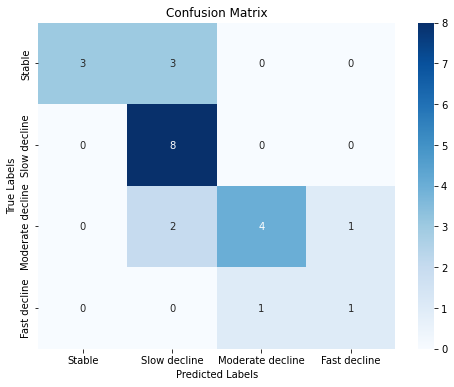

Weighted Sensitivity: 0.6957
Weighted Specificity: 0.8609
                       AUC
Slow decline      0.925000
Moderate decline  0.816964
Fast decline      0.976190
Stable            0.789216
0.8611489160881745
13
15


C:\Users\25110\AppData\Local\Temp/ipykernel_5184/2757640877.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={
C:\Users\25110\AppData\Local\Temp/ipykernel_5184/2757640877.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Prediction'] = df[['Slow decline', 'Moderate decline', 'Fast decline', 'Stable']].idxmax(axis=1)


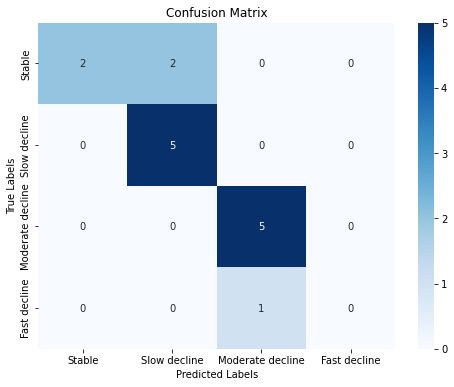

Weighted Sensitivity: 0.8000
Weighted Specificity: 0.9000
                       AUC
Slow decline      0.740000
Moderate decline  1.000000
Fast decline      1.000000
Stable            0.954545
0.9012121212121212
14
8


C:\Users\25110\AppData\Local\Temp/ipykernel_5184/2757640877.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={
C:\Users\25110\AppData\Local\Temp/ipykernel_5184/2757640877.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Prediction'] = df[['Slow decline', 'Moderate decline', 'Fast decline', 'Stable']].idxmax(axis=1)


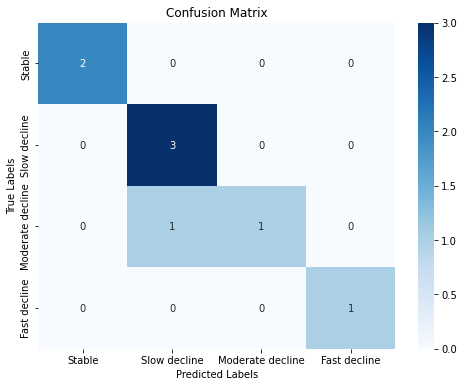

Weighted Sensitivity: 0.8750
Weighted Specificity: 0.9250
                       AUC
Slow decline      0.333333
Moderate decline  1.000000
Fast decline      1.000000
Stable            1.000000
0.75


In [131]:
# Count the occurrences of each RID
data = pd.read_csv("D:\\Research\\AD\\ADLLM\\ADNI process 9\\ADNI\\ADNI-results\\ADNI_probability_MMSE_visit_times.csv")
for k in range(1,15):
    df = data[data['Visit time mmse'] == k]
    print(k)
    print(df.shape[0])
    df.rename(columns={
    'MMSE-Slow': 'Slow decline',
    'MMSE-Moderate': 'Moderate decline',
    'MMSE-Fast': 'Fast decline',
    'MMSE-Not decreasing':'Stable'
}, inplace=True)

# Step 2: Generate 'Prediction' column based on max probability
    df['Prediction'] = df[['Slow decline', 'Moderate decline', 'Fast decline', 'Stable']].idxmax(axis=1)

# Step 3: Filter out rows where 'Truth' is 'Unknown'
    df_filtered = df[df['Truth'] != 'Unknown.']
    y_true = df_filtered["Truth"]
    y_pred = df_filtered["Prediction"]
    desired_order = [ 'Stable','Slow decline', 'Moderate decline', 'Fast decline']
# Filter out 'Unknown' class from both true and predicted labels
    mask = (y_true != 'Unknown.') & (y_pred != 'Unknown.')
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]

# Compute the confusion matrix
    cm = confusion_matrix(y_true_filtered, y_pred_filtered, labels=desired_order)

# Create a heatmap to visualize the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=desired_order, yticklabels=desired_order)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
# 初始化敏感性和特异性的列表
    sensitivities = []
    specificities = []
    class_weights = []

# 遍历每个类别计算敏感性和特异性
    for i in range(len(cm)):
        TP = cm[i, i]
        FN = np.sum(cm[i, :]) - TP
        FP = np.sum(cm[:, i]) - TP
        TN = np.sum(cm) - (TP + FN + FP)
    
        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    
        sensitivities.append(sensitivity)
        specificities.append(specificity)
    
    # 权重为该类别的真实样本数
        class_weights.append(TP + FN)

# 计算加权平均敏感性和特异性
    weighted_sensitivity = np.average(sensitivities, weights=class_weights)
    weighted_specificity = np.average(specificities, weights=class_weights)

    print(f"Weighted Sensitivity: {weighted_sensitivity:.4f}")
    print(f"Weighted Specificity: {weighted_specificity:.4f}")
    from sklearn.metrics import roc_auc_score
    import pandas as pd

# Assuming MMSE is a pandas Series and filtered_df is a DataFrame

# Create a dictionary to store the AUC for each class
    auc_scores = {}
    cate=['Slow decline', 'Moderate decline', 'Fast decline', 'Stable']
    class_weights = []


# Iterate through each class in filtered_df columns
    for i,cls in enumerate(cate):
    # Convert MMSE to binary: 1 if the class matches, 0 otherwise
        binary_true_labels = ( df_filtered["Truth"]== cls).astype(int)
    
    # Get the predicted probabilities for the current class
        pred_probs = df_filtered.iloc[:,i+1]
    # Calculate the AUC for the current class
        auc_number = roc_auc_score(binary_true_labels, pred_probs)
        class_weights.append(sum(df_filtered["Truth"] == cls))
    # Store the AUC in the dictionary
        auc_scores[cls] = auc_number

# Convert the dictionary to a DataFrame for easier viewing
    auc_df = pd.DataFrame.from_dict(auc_scores, orient='index', columns=['AUC'])
    print(auc_df)
    weighted_auc = np.average(auc_df['AUC'], weights=class_weights)
    print(weighted_auc)
    
    



1
469


C:\Users\25110\AppData\Local\Temp/ipykernel_5184/244318459.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={
C:\Users\25110\AppData\Local\Temp/ipykernel_5184/244318459.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Prediction'] = df[['Slow decline', 'Moderate decline', 'Fast decline', 'Stable']].idxmax(axis=1)


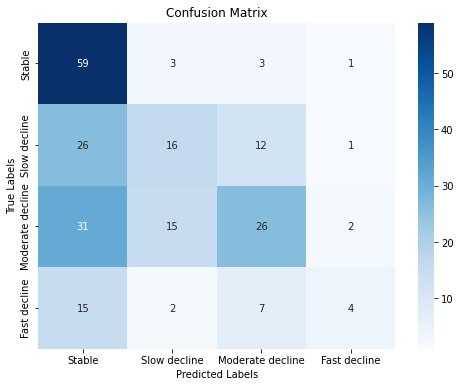

Weighted Sensitivity: 0.4709
Weighted Specificity: 0.7833
                       AUC
Slow decline      0.637121
Moderate decline  0.674950
Fast decline      0.639194
Stable            0.794152
0.6964099732187816
2
223


C:\Users\25110\AppData\Local\Temp/ipykernel_5184/244318459.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={
C:\Users\25110\AppData\Local\Temp/ipykernel_5184/244318459.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Prediction'] = df[['Slow decline', 'Moderate decline', 'Fast decline', 'Stable']].idxmax(axis=1)


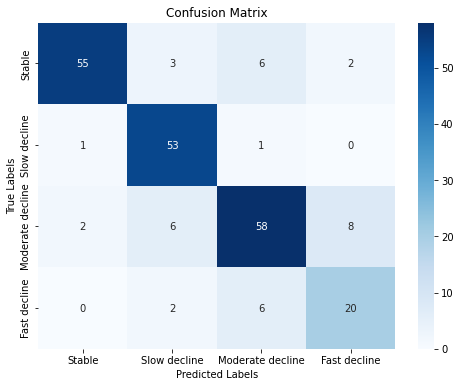

C:\Users\25110\AppData\Local\Temp/ipykernel_5184/244318459.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={
C:\Users\25110\AppData\Local\Temp/ipykernel_5184/244318459.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Prediction'] = df[['Slow decline', 'Moderate decline', 'Fast decline', 'Stable']].idxmax(axis=1)


Weighted Sensitivity: 0.8341
Weighted Specificity: 0.9428
                       AUC
Slow decline      0.971104
Moderate decline  0.929349
Fast decline      0.943040
Stable            0.949817
0.9474240029621136
3
50


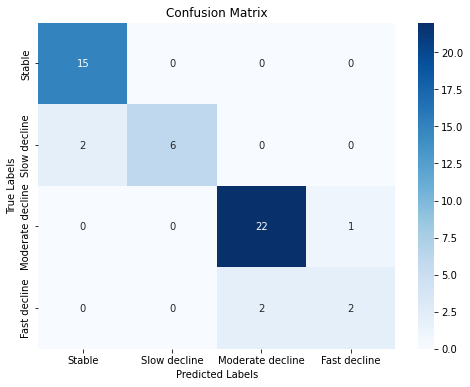

Weighted Sensitivity: 0.9000
Weighted Specificity: 0.9470
                       AUC
Slow decline      0.979167
Moderate decline  0.995169
Fast decline      0.978261
Stable            0.990476
0.989848171152519


In [134]:
# Count the occurrences of each RID
data = pd.read_csv("D:\\Research\\AD\\ADLLM\\ADNI process 9\\HABS-HD\\HABS-HD-results\\HABS_probability_MMSE_visit_times.csv")
for k in range(1,4):
    df = data[data['Visit_ID'] == k]
    print(k)
    print(df.shape[0])
    df.rename(columns={
    'MMSE-Slow': 'Slow decline',
    'MMSE-Moderate': 'Moderate decline',
    'MMSE-Fast': 'Fast decline',
    'MMSE-Not decreasing':'Stable'
}, inplace=True)

# Step 2: Generate 'Prediction' column based on max probability
    df['Prediction'] = df[['Slow decline', 'Moderate decline', 'Fast decline', 'Stable']].idxmax(axis=1)

# Step 3: Filter out rows where 'Truth' is 'Unknown'
    df_filtered = df[df['Truth'] != 'Unknown.']
    y_true = df_filtered["Truth"]
    y_pred = df_filtered["Prediction"]
    desired_order = [ 'Stable','Slow decline', 'Moderate decline', 'Fast decline']
# Filter out 'Unknown' class from both true and predicted labels
    mask = (y_true != 'Unknown.') & (y_pred != 'Unknown.')
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]

# Compute the confusion matrix
    cm = confusion_matrix(y_true_filtered, y_pred_filtered, labels=desired_order)

# Create a heatmap to visualize the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=desired_order, yticklabels=desired_order)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
# 初始化敏感性和特异性的列表
    sensitivities = []
    specificities = []
    class_weights = []

# 遍历每个类别计算敏感性和特异性
    for i in range(len(cm)):
        TP = cm[i, i]
        FN = np.sum(cm[i, :]) - TP
        FP = np.sum(cm[:, i]) - TP
        TN = np.sum(cm) - (TP + FN + FP)
    
        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    
        sensitivities.append(sensitivity)
        specificities.append(specificity)
    
    # 权重为该类别的真实样本数
        class_weights.append(TP + FN)

# 计算加权平均敏感性和特异性
    weighted_sensitivity = np.average(sensitivities, weights=class_weights)
    weighted_specificity = np.average(specificities, weights=class_weights)

    print(f"Weighted Sensitivity: {weighted_sensitivity:.4f}")
    print(f"Weighted Specificity: {weighted_specificity:.4f}")
    from sklearn.metrics import roc_auc_score
    import pandas as pd

# Assuming MMSE is a pandas Series and filtered_df is a DataFrame

# Create a dictionary to store the AUC for each class
    auc_scores = {}
    cate=['Slow decline', 'Moderate decline', 'Fast decline', 'Stable']
    class_weights = []


# Iterate through each class in filtered_df columns
    for i,cls in enumerate(cate):
    # Convert MMSE to binary: 1 if the class matches, 0 otherwise
        binary_true_labels = ( df_filtered["Truth"]== cls).astype(int)
    
    # Get the predicted probabilities for the current class
        pred_probs = df_filtered.iloc[:,i+1]
    # Calculate the AUC for the current class
        auc_number = roc_auc_score(binary_true_labels, pred_probs)
        class_weights.append(sum(df_filtered["Truth"] == cls))
    # Store the AUC in the dictionary
        auc_scores[cls] = auc_number

# Convert the dictionary to a DataFrame for easier viewing
    auc_df = pd.DataFrame.from_dict(auc_scores, orient='index', columns=['AUC'])
    print(auc_df)
    weighted_auc = np.average(auc_df['AUC'], weights=class_weights)
    print(weighted_auc)
    
    


